# VideoMAEv2 model availables

### Pre-train

| Model | Config | Dataset | 
| :---: | :----  | :-----: | 
| ViT-giant | vit_g_hybrid_pt_1200e | UnlabeledHybrid | 

### Fine-tune
| Model | Config | Dataset | Pre-train | Post-pre-train |
| :---: | :----  | :-----: | :-------: | :------------: |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_ft | K710 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k400_ft | K400 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k400_ft | K400 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k600_ft | K600 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_ssv2_ft | SSv2 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_ucf101_ft | UCF101 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_hmdb51_ft | HMDB51 | UnlabeledHybrid | K710 |

### Distillation from giant
|  Model  | Dataset | Teacher Model  |
| :-----: | :-----: | :-----------: |
| ViT-small | K710 | vit_g_hybrid_pt_1200e_k710_ft |
| ViT-base | K710 | vit_g_hybrid_pt_1200e_k710_ft | 

### Model details

|  model  | frame channels | frame sampling | frame size (H,W) | tubelet size | patch size | emb dim | output tensor | mem(GB) |
| :-----: | :-----: | :-----------: | :-----: | :-----: | :-----------: | :-----: | :-----: |:----|
| giant | 3 | 16 | (224,224) | 2 | (14,14) | 1408 | [8,16,16,1408] | 4.0 |
| base | 3 | 16 | (224,224) | 2 | (16,16) | 768 | [8,14,14,768] | 0.4|
| small | 3 | 16 | (224,224) | 2 | (16,16) | 384 | [8,14,14,1408] | 0.09|
 


# Code (w/ lib) 

Add sanity check when init to see if folders and custom methods are created

Kernel: RBF that can handle non-linear pattern
C: Low to avoid overfit
eps:  high values lead to a simpler model but potentially less precise predictions
      low values require tighter predictions, which can make the model more complex

WHAT I HAVE:

CLIPS_REDUCTION values:
  MEAN: 0 (applied in action recognition)
  GRU: lstm (work in progress)

EMBEDDING_REDUCTION values:
  MEAN_TEMPORAL: 1      [keep spatial information]
  MEAN_SPATIAL: (2, 3)  [keep temporal information]
  MEAN_TEMPORAL_SPATIAL: (1, 2, 3) [applied in action recognition]
  GRU: GRU (work in progress)

MODEL_TYPE values:
  VIDEOMAE_v2_S: smaller model
  VIDEOMAE_v2_B: base model
  VIDEOMAE_v2_G_pt_1200e: giant model w/h intermediate fine-tuning
  VIDEOMAE_v2_G_pt_1200e_K710_it_HMDB51_ft: giant model fine-tuned

SAMPLE_FRAME_STRATEGY values:
  UNIFORM: uniform
  SLIDING_WINDOW: sliding_window
  CENTRAL_SAMPLING: central_sampling
  RANDOM_SAMPLING: random_sampling

HEAD
  SVR
____________________________________________________________________________


TESTING SETTINGS GRID_SEARCH
model_type = MODEL_TYPE.VIDEOMAE_v2_B
embedding_reduction = EMBEDDING_REDUCTION.MEAN_TEMPORAL_SPATIAL
clips_reduction = CLIPS_REDUCTION.MEAN
sample_frame_strategy = SAMPLE_FRAME_STRATEGY.UNIFORM

path_labels = os.path.join('partA','starting_point','subsamples_100_400.csv') # 110 samples per class, 400 samples in total
path_dataset = os.path.join('partA','video','video')
k_cross validation = 5 (Stratified K-Fold cross-validator-> The folds are made by preserving the percentage of samples for each class.)

grid_search = {
  'kernel': ['rbf'],
  'C': [0.1, 1, 10],
  'epsilon': [0.1, 1, 10, 100],
}

Form table we have:
  best_estimator ={
    kernel:'rbf',
    'C': [0.1, 1, 10]
    'epsilon':[10, 100]
  }

<div style="overflow-x: auto;">

In [3]:
from custom.helper import CLIPS_REDUCTION,EMBEDDING_REDUCTION,MODEL_TYPE,SAMPLE_FRAME_STRATEGY, HEAD
import os
from custom.model import Model_Advanced
from transformers import AutoImageProcessor
from custom.head import HeadSVR, HeadGRU
import time

In [8]:
%load_ext autoreload
%autoreload 2

model_type = MODEL_TYPE.VIDEOMAE_v2_B
embedding_reduction = EMBEDDING_REDUCTION.MEAN_SPATIAL
# clips_reduction = CLIPS_REDUCTION.MEAN
# embedding_reduction = None
clips_reduction = CLIPS_REDUCTION.NONE
sample_frame_strategy = SAMPLE_FRAME_STRATEGY.SLIDING_WINDOW

# path_labels = os.path.join('partA','starting_point','samples.csv')
# 'original' : os.path.join('partA','starting_point','subsamples_60_240.csv'),
# path_dict ={
  
#   'train' : os.path.join('partA','starting_point','train_191.csv'),
#   'val' : os.path.join('partA','starting_point','val_26.csv'),
#   'test' : os.path.join('partA','starting_point','test_23.csv')
# }
path_dict ={
  'all' : os.path.join('partA','starting_point','train_191.csv'),
  'train' : os.path.join('partA','starting_point','train_21.csv'),
  'val' : os.path.join('partA','starting_point','val_26'),
  'test' : os.path.join('partA','starting_point','test_5.csv')
}

path_dataset = os.path.join('partA','video','video')  
# head = HeadSVR(svr_params={'kernel':'rbf','C':1,'epsilon':10})
head = 'GRU'
if head == 'GRU':
  params = {
    'hidden_size': 512,
    'num_layers': 1,
    'dropout': 0.0
  }
else: 
  params ={
    'kernel':'rbf',
    'C':1,
    'epsilon':10
  }
# print(f'\npath_labels: {path_labels}\n')

preprocess = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")

model_advanced = Model_Advanced(model_type=model_type,
                                path_dataset=path_dataset,
                                embedding_reduction=embedding_reduction,
                                clips_reduction=clips_reduction,
                                sample_frame_strategy=sample_frame_strategy,
                                stride_window=70,
                                path_labels=path_dict['all'],
                                preprocess=preprocess,
                                batch_size=1,
                                head=head,
                                head_params=params,
                                download_if_unavailable=True
                                ) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
head_params : {'hidden_size': 512, 'num_layers': 1, 'dropout': 0.0, 'input_size': 6144}
output_tensor : [1, 8, 1, 1, 768]


In [13]:
tens.sum(1)

tensor([5, 1, 0, 2, 0])

{'accuracy_per_class': tensor([   nan, 0.6667, 1.0000, 0.0000,    nan]),
 'mean_accuracy': tensor(0.5556),
 'mean_weighted_accuracy': tensor(0.2727)}

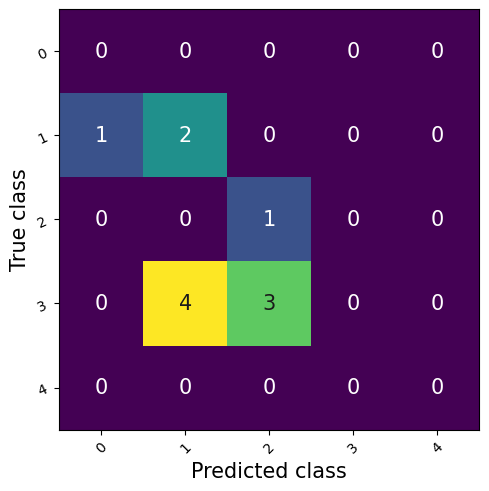

In [15]:
from torchmetrics.classification import ConfusionMatrix
import torch
import custom.tools as tools

confusion_matrix = ConfusionMatrix(task='multiclass',num_classes=5)
pred__ = torch.tensor([0,1,1,2,1,2,2,1,1,2,1])
target = torch.tensor([1,3,3,2,1,3,3,3,3,3,1])
confusion_matrix.update(pred__, target)
tens=confusion_matrix.compute()
confusion_matrix.plot()
tools.get_accuracy_from_confusion_matrix(tens)

In [6]:
import numpy as np
np.unique([0,1,2,3]).shape[0]

4

In [12]:
import torch

tensor = torch.arange(10).unsqueeze(1).repeat(1, 8).T
idx = [3,2,4,1,2,3,4,3]
print(tensor[torch.arange(tensor.size(0)), idx])

tensor([3, 2, 4, 1, 2, 3, 4, 3])


In [5]:
import torch
arr = torch.rand((8,13,50))
idx = torch.tensor([0,0,0])
arr[:,idx,:].shape

torch.Size([8, 3, 50])

In [1]:
import torch
torch.cuda.is_available()

True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
head_params : {'hidden_size': 512, 'num_layers': 1, 'dropout': 0.0, 'input_size': 384}
output_tensor : [1, 1, 1, 1, 384]
Start training phase the model at history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733437789
Generating train, test and validation csv files
nr_train_samples: 18
nr_test_samples: 2
nr_val_samples: 3
train split saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733437789/train_GRU/train.csv
val split saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733437789/train_GRU/val.csv
test split saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733437789/train_GRU/test.csv
Plotting train,test,val distribution
Training model
training using validation set
Training using GRU.....
GRU extract features from history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733437789/train_GRU/train.csv
extracting f

/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/torchmetrics/utilities/plot.py:269: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(nrows=rows, ncols=cols, constrained_layout=True) if ax is None else (ax.get_figure(), ax)


Plot precision_per_class over Epochs  saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733437789/train_GRU/confusion_matricies/plot_over_epochs/precision_per_class.png.png
Plot recall_per_class over Epochs  saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733437789/train_GRU/confusion_matricies/plot_over_epochs/recall_per_class.png.png
Plot macro_precision over Epochs  saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733437789/train_GRU/confusion_matricies/plot_over_epochs/macro_precision.png.png
Plot macro_recall over Epochs  saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733437789/train_GRU/confusion_matricies/plot_over_epochs/macro_recall.png.png
Plot micro_precision over Epochs  saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733437789/train_GRU/confusion_matricies/plot_over_epochs/micro_precision.png.png
Plot micro_recall over Epochs  saved to history_run/VIDE

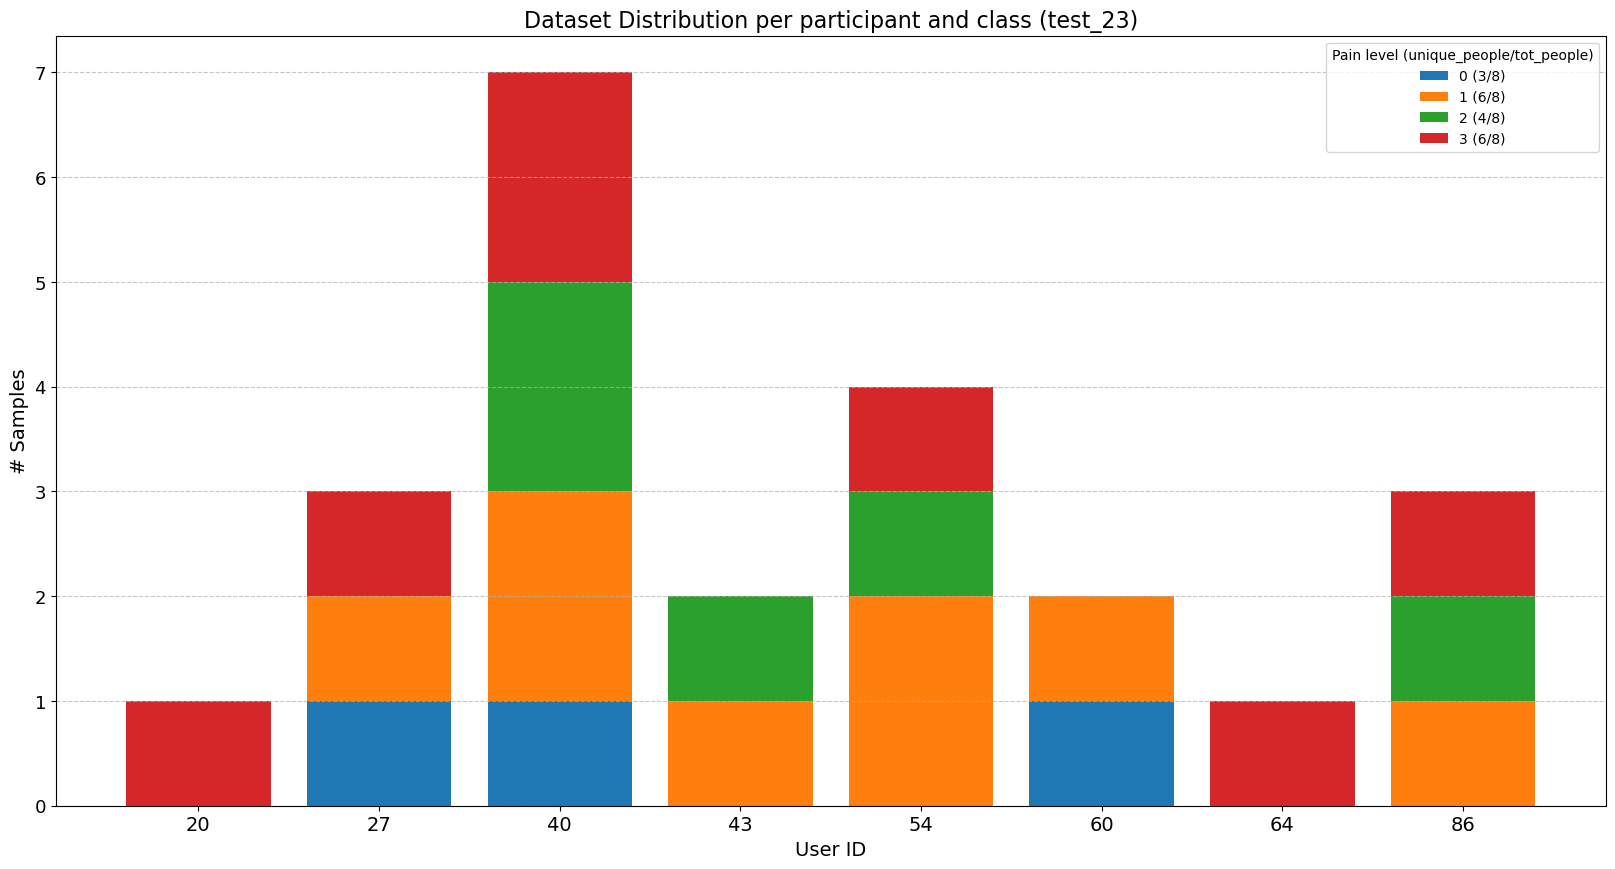

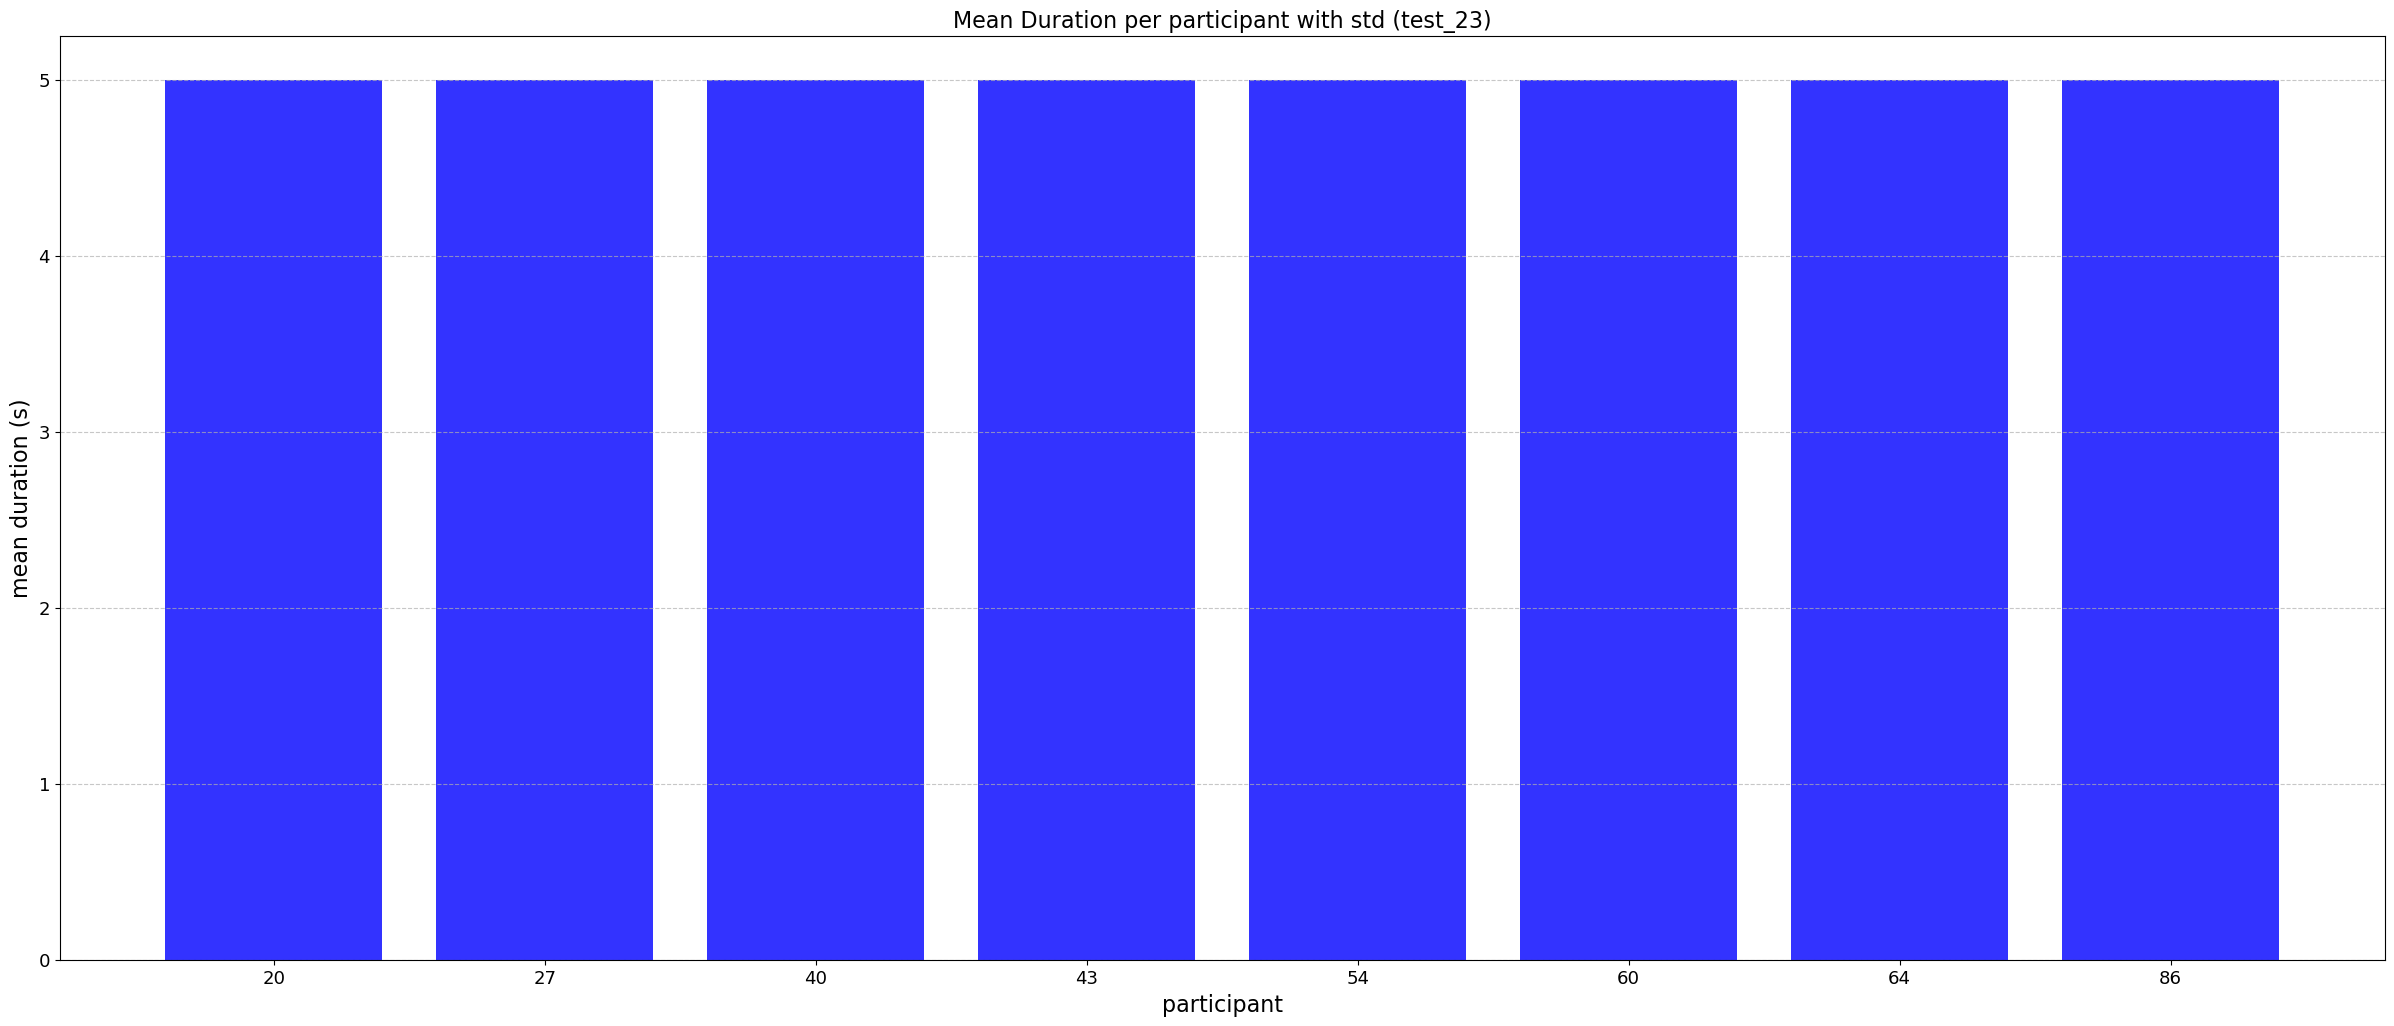

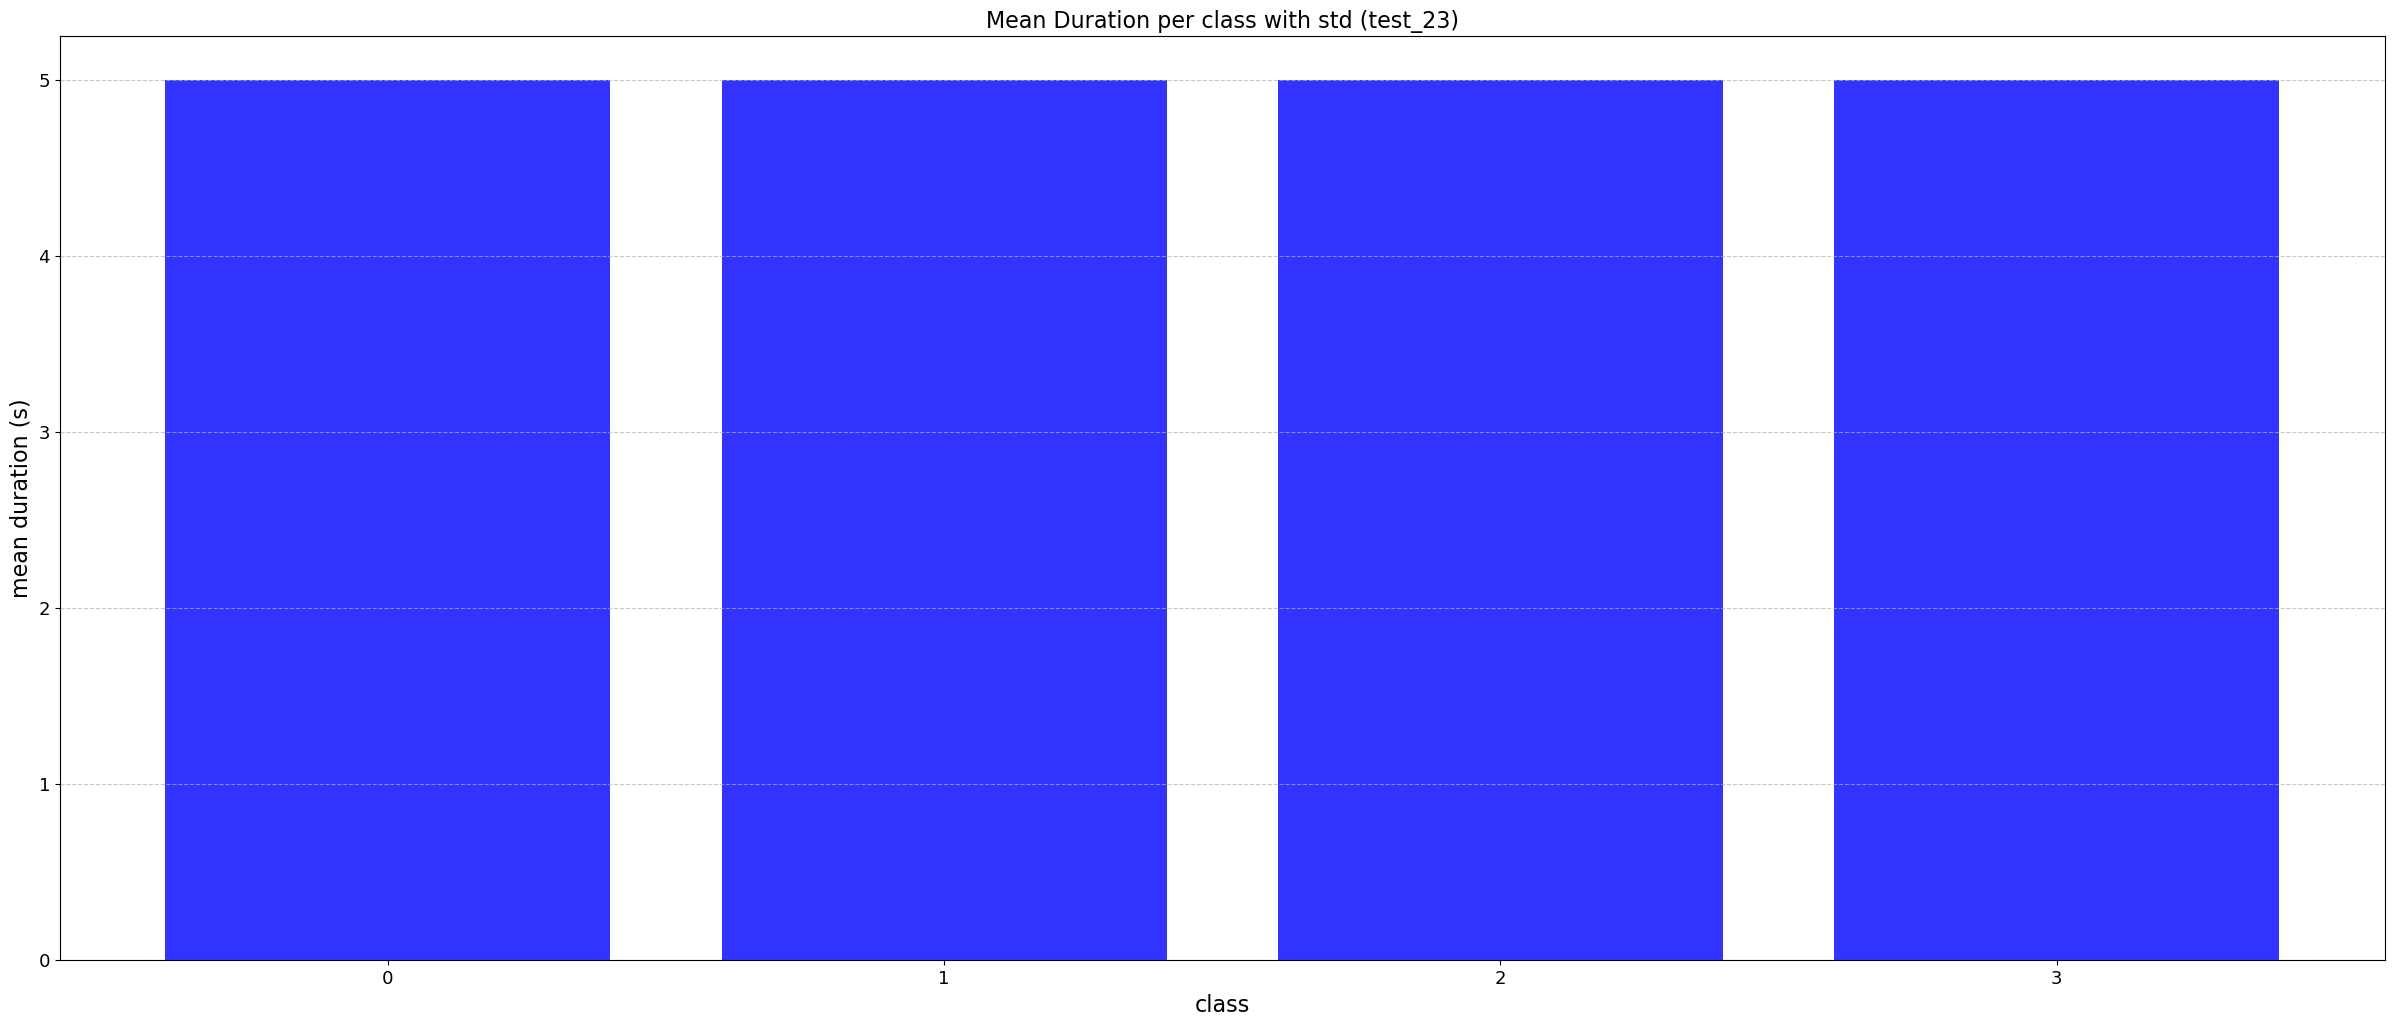

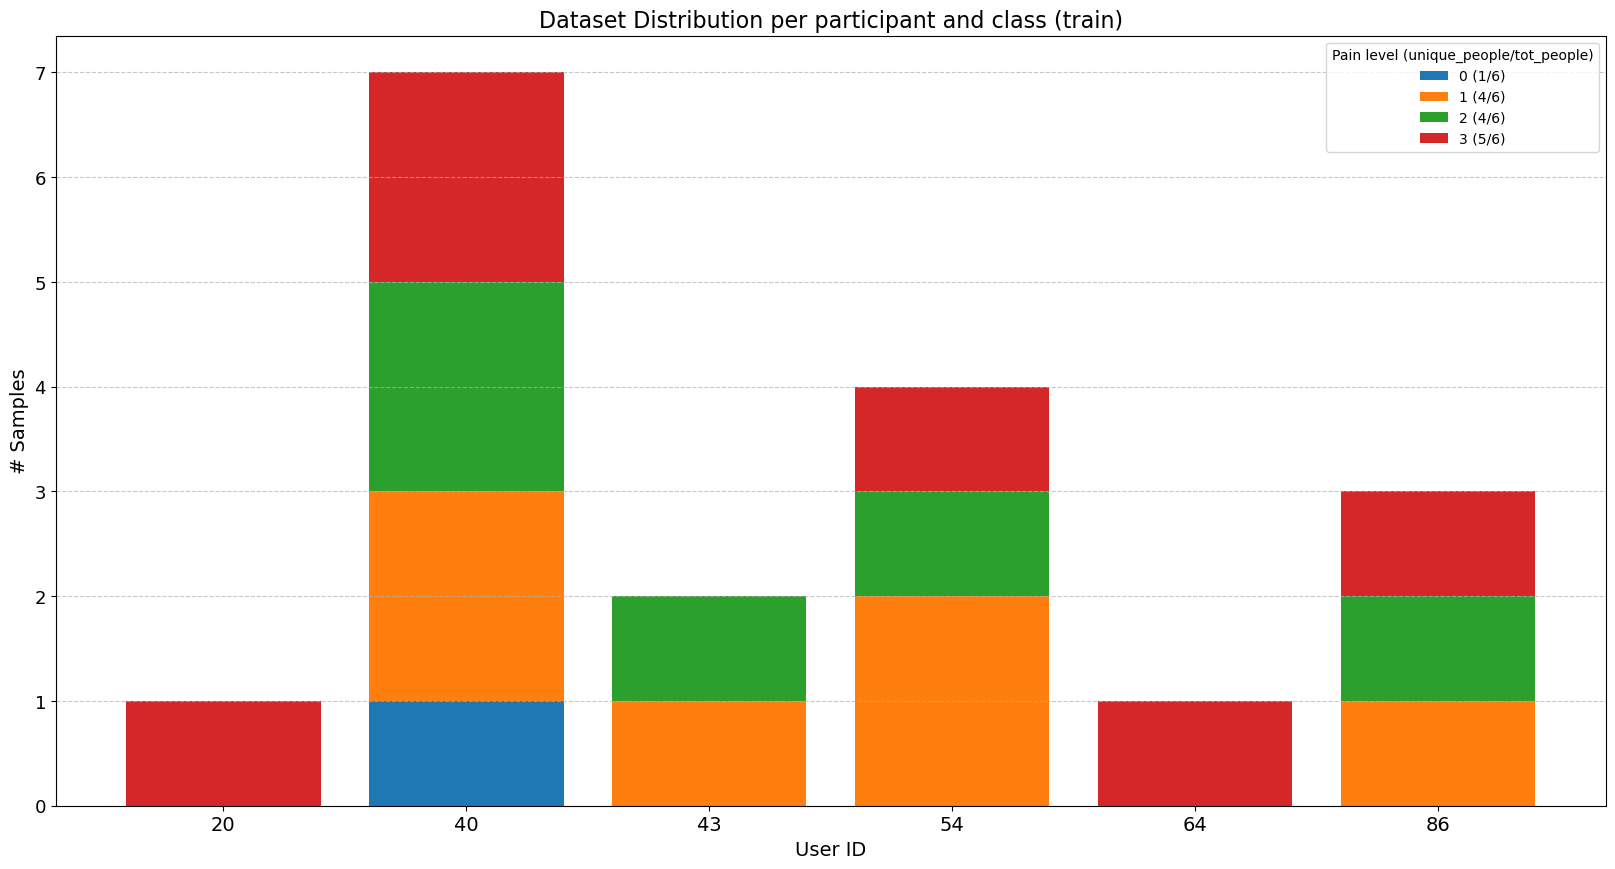

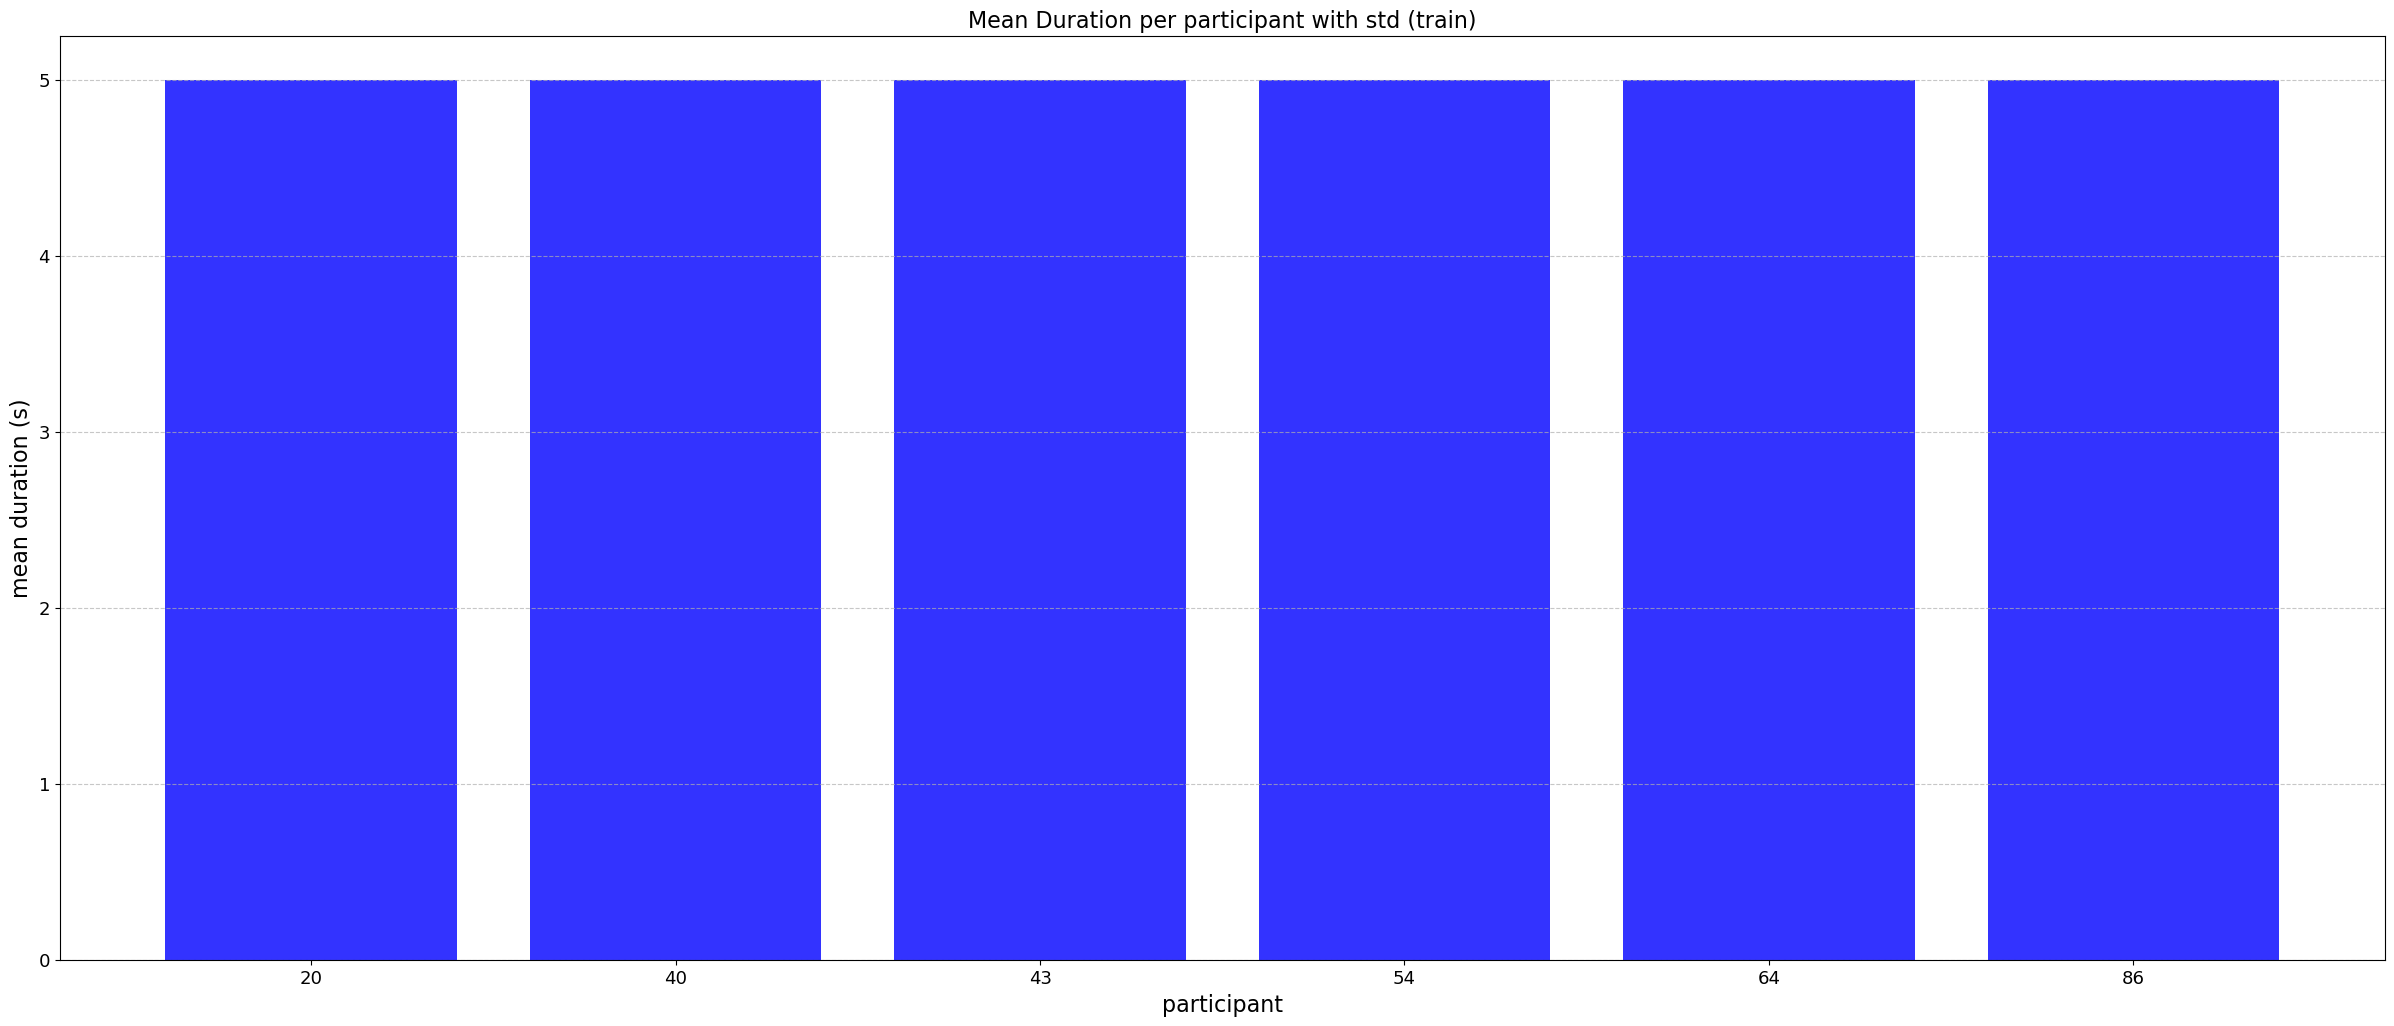

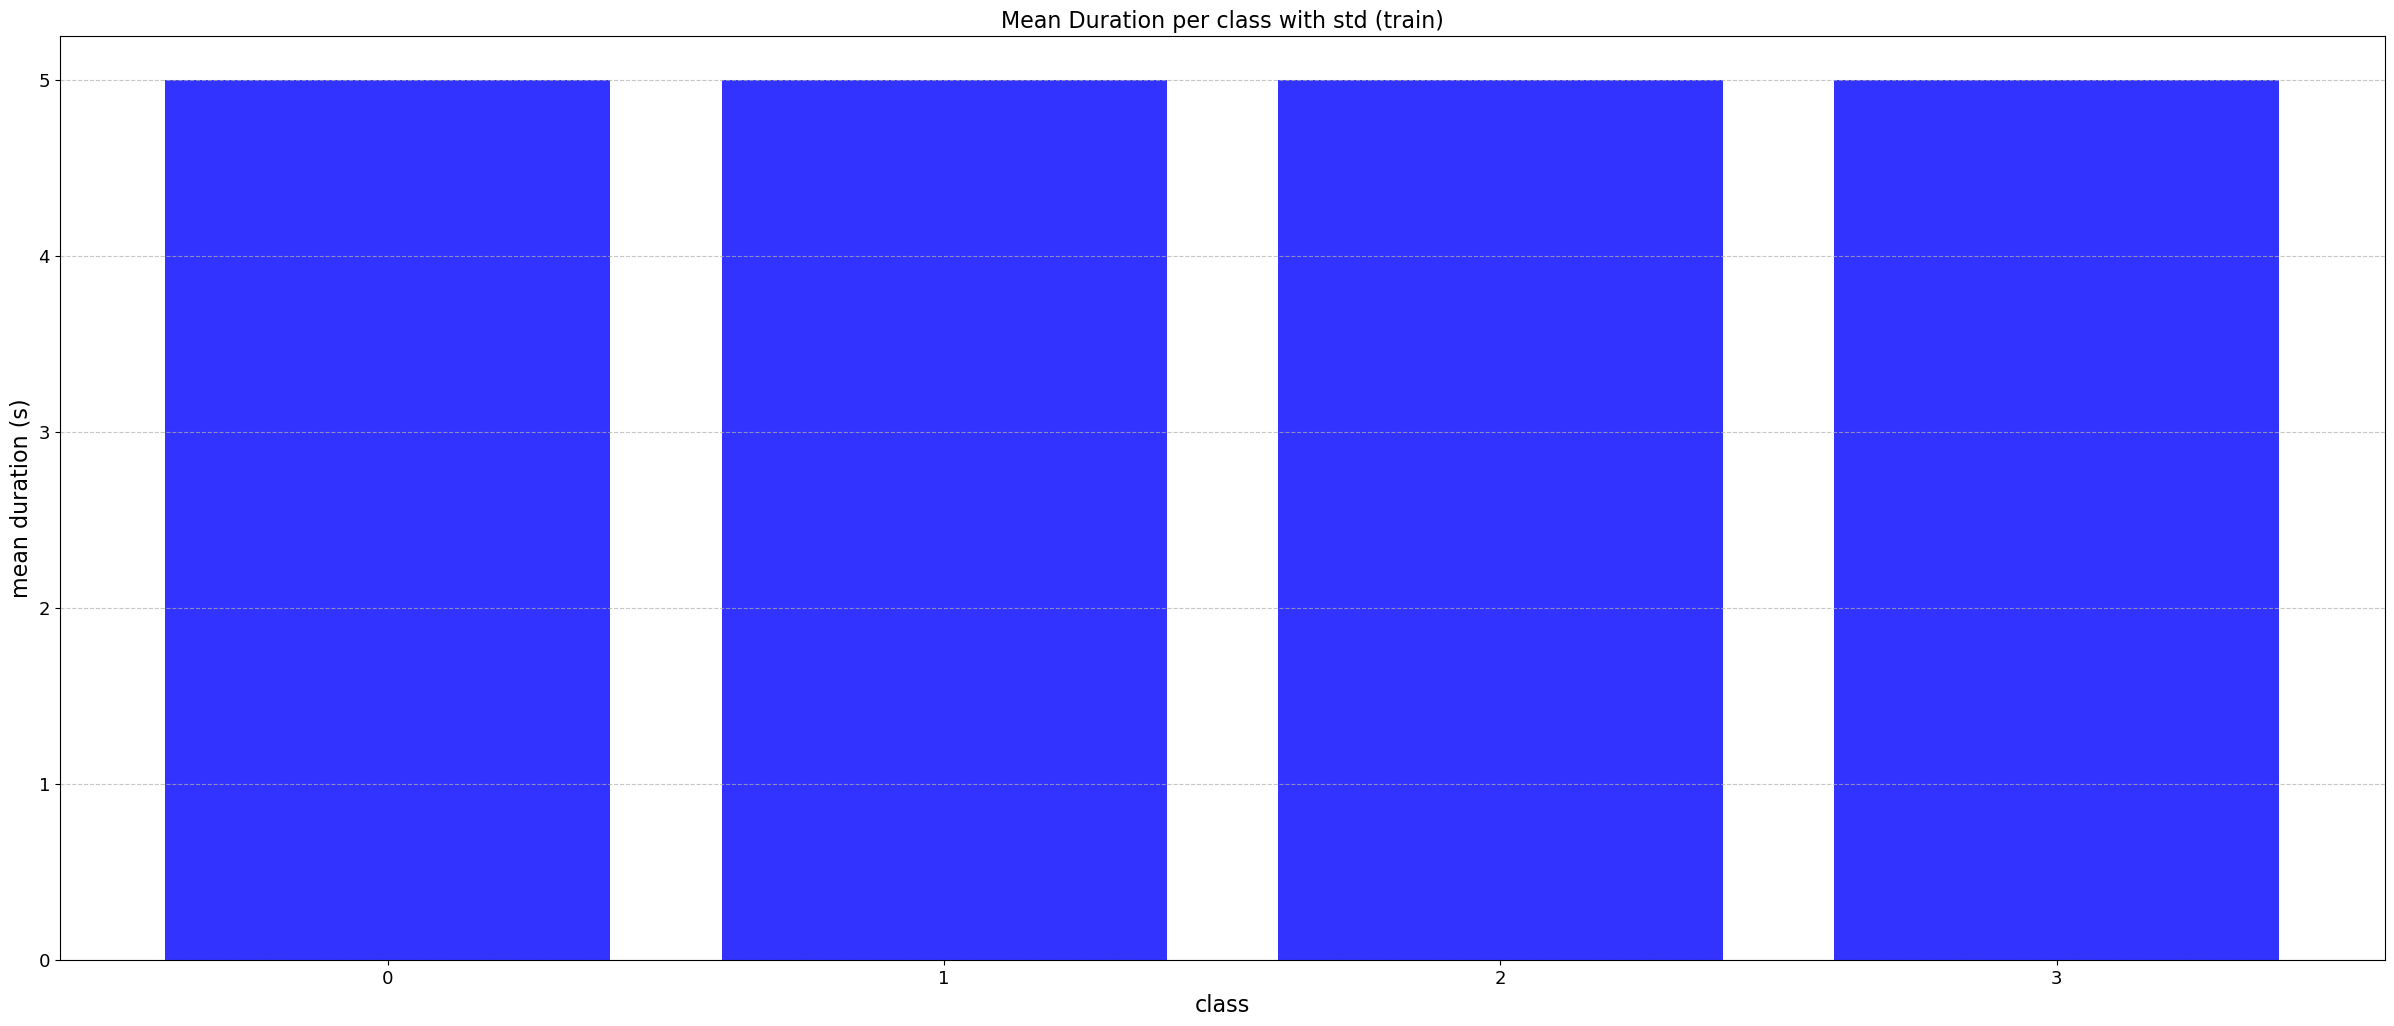

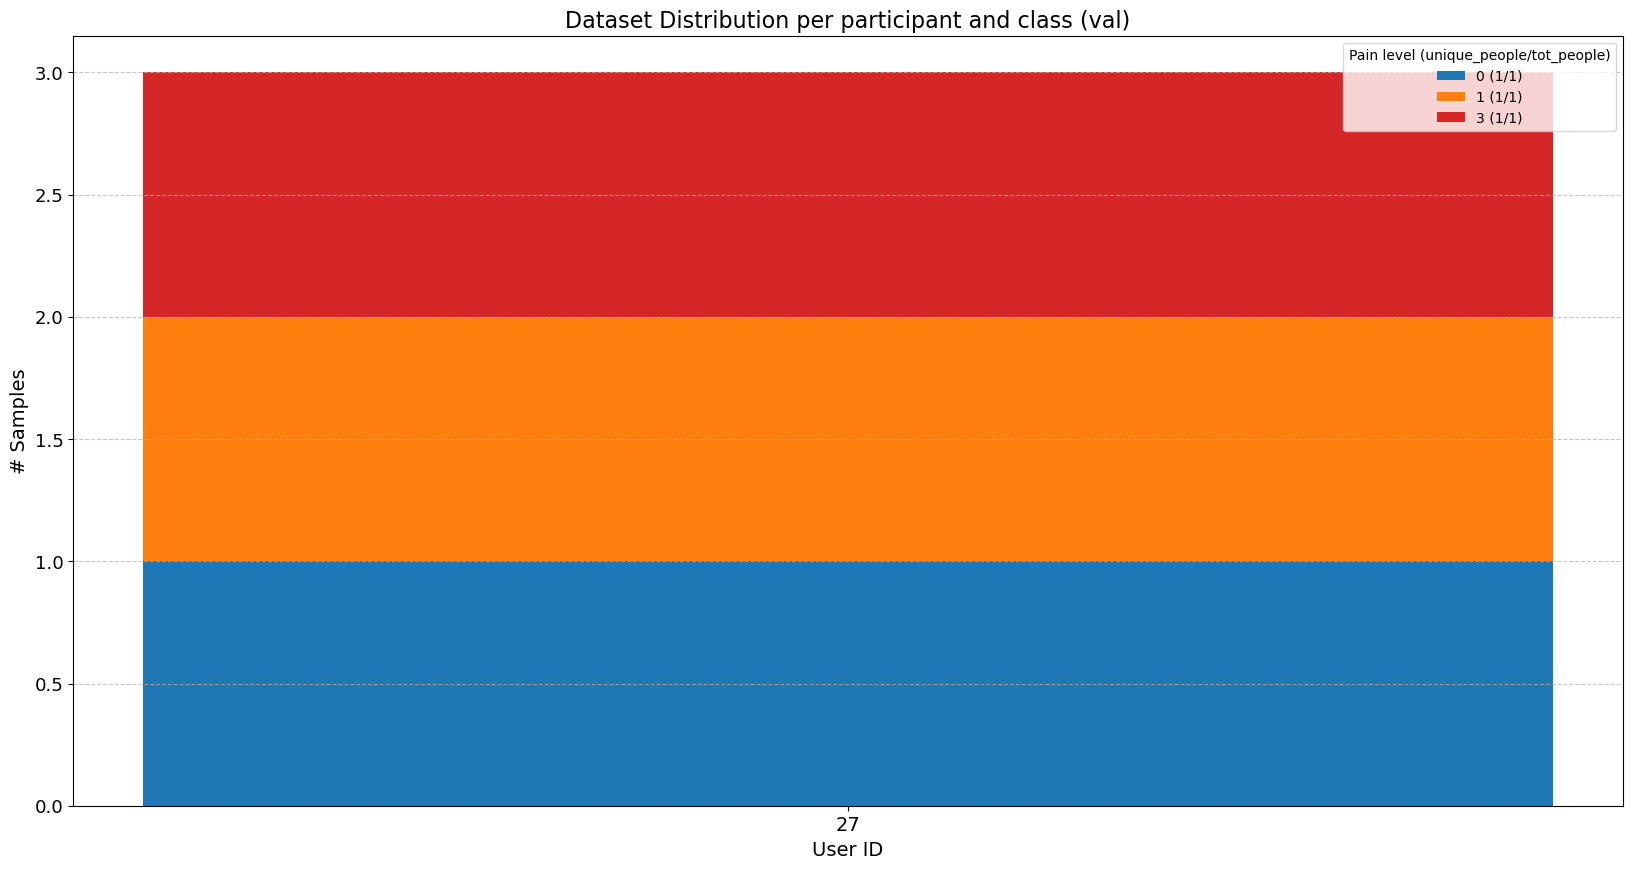

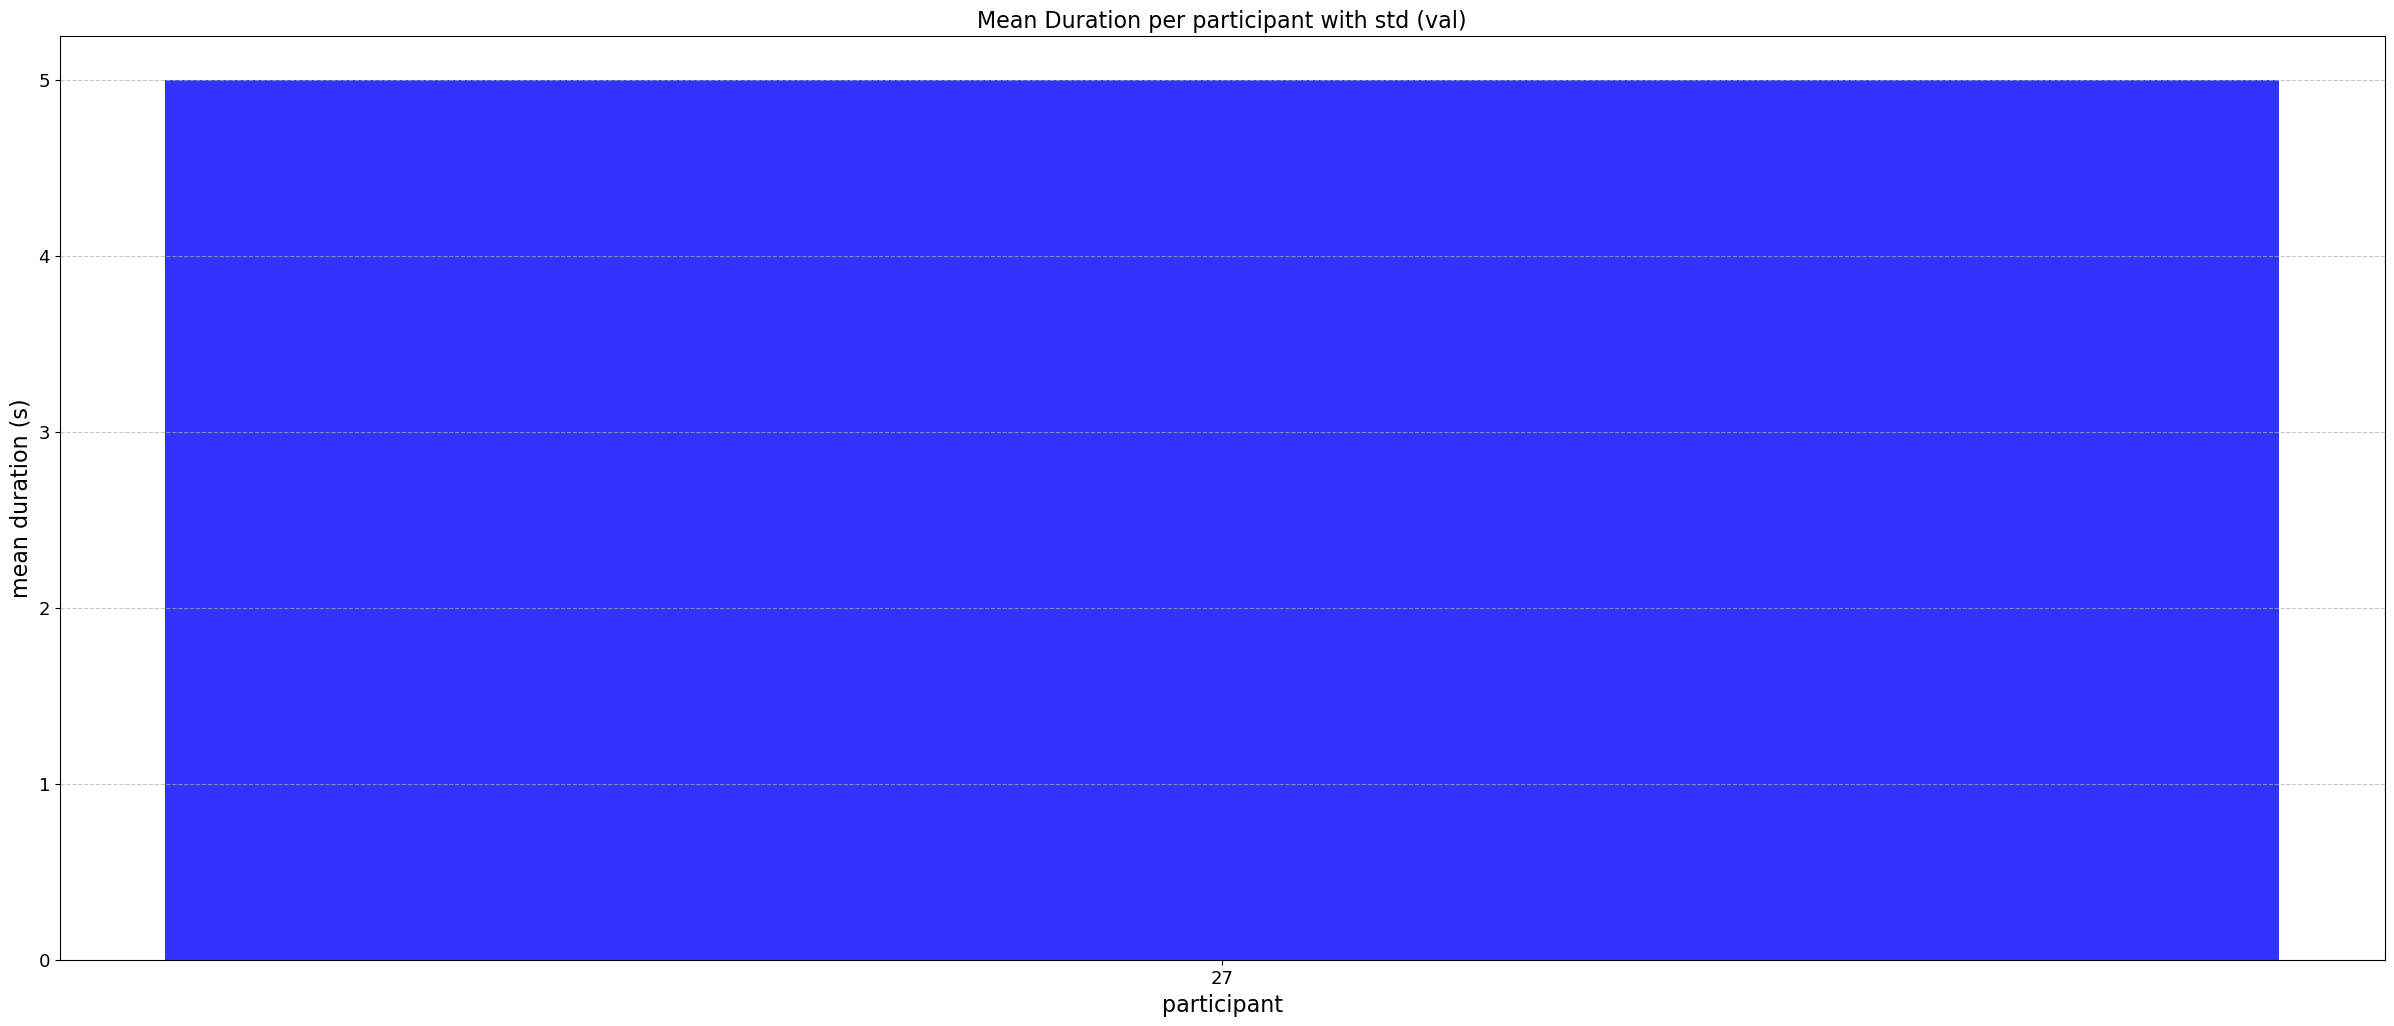

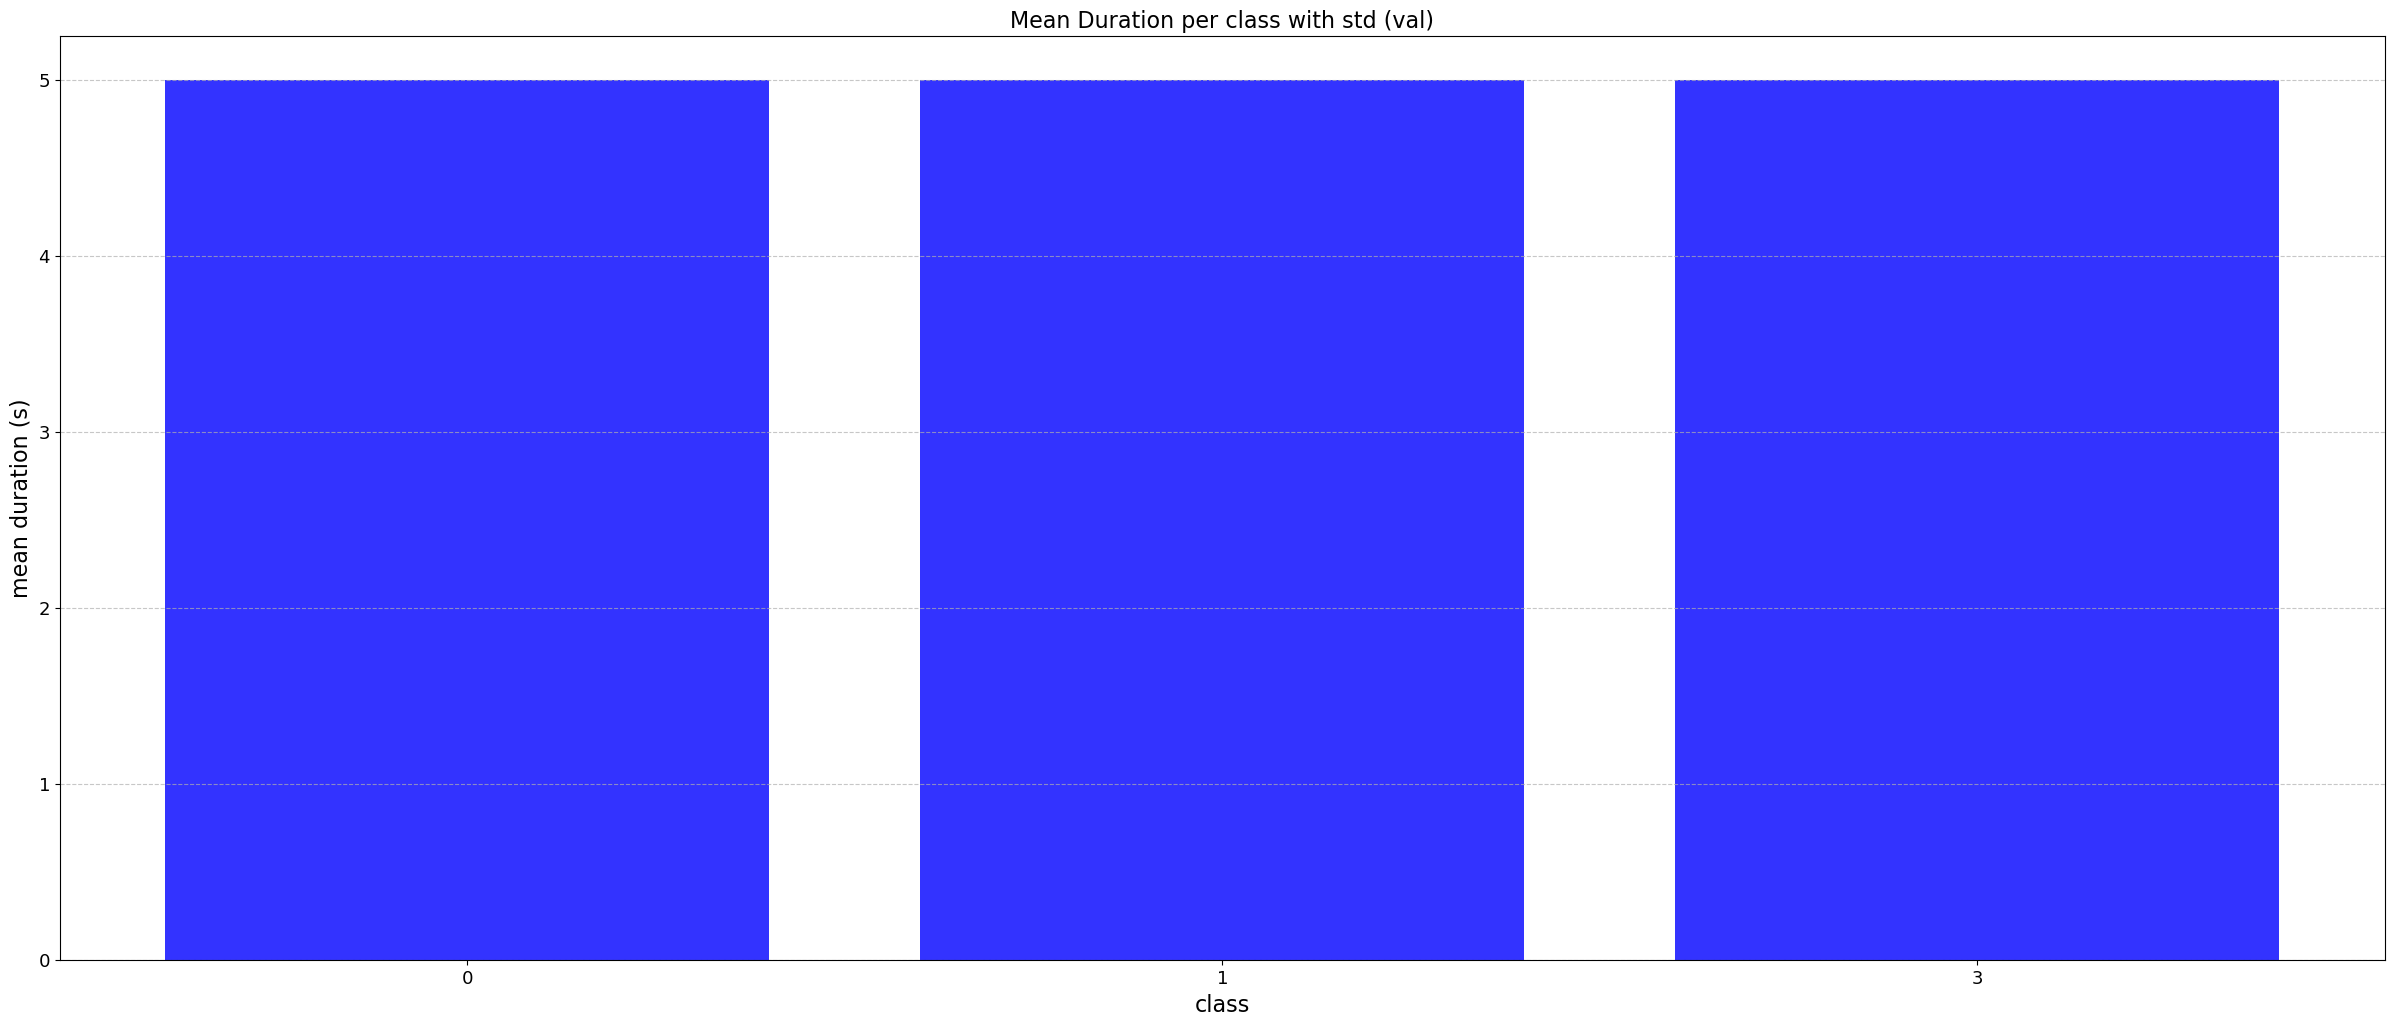

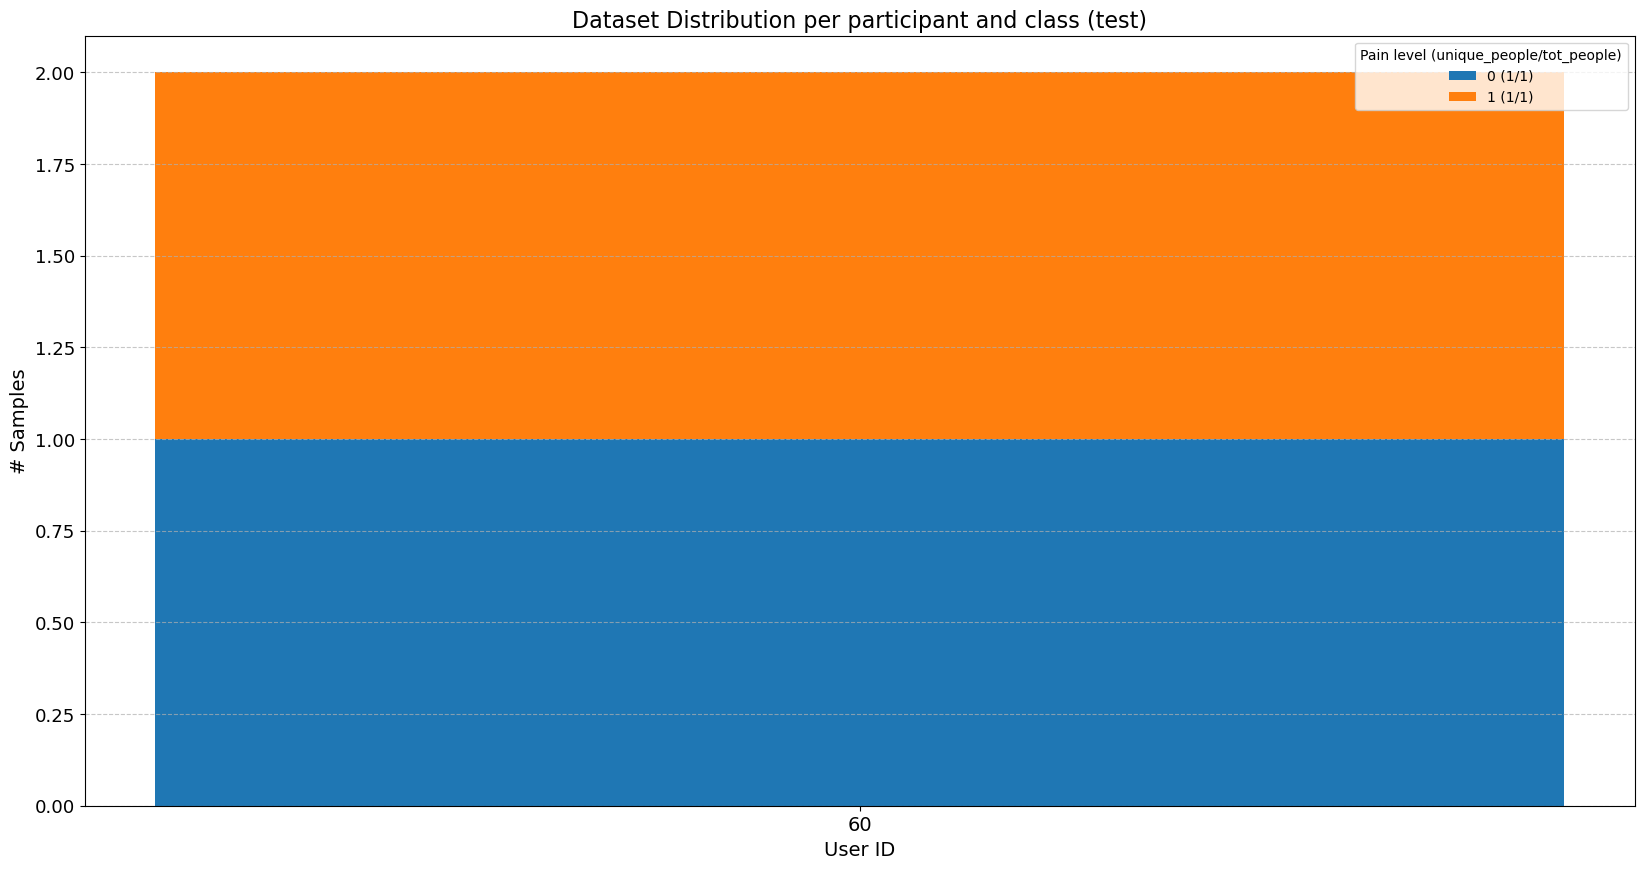

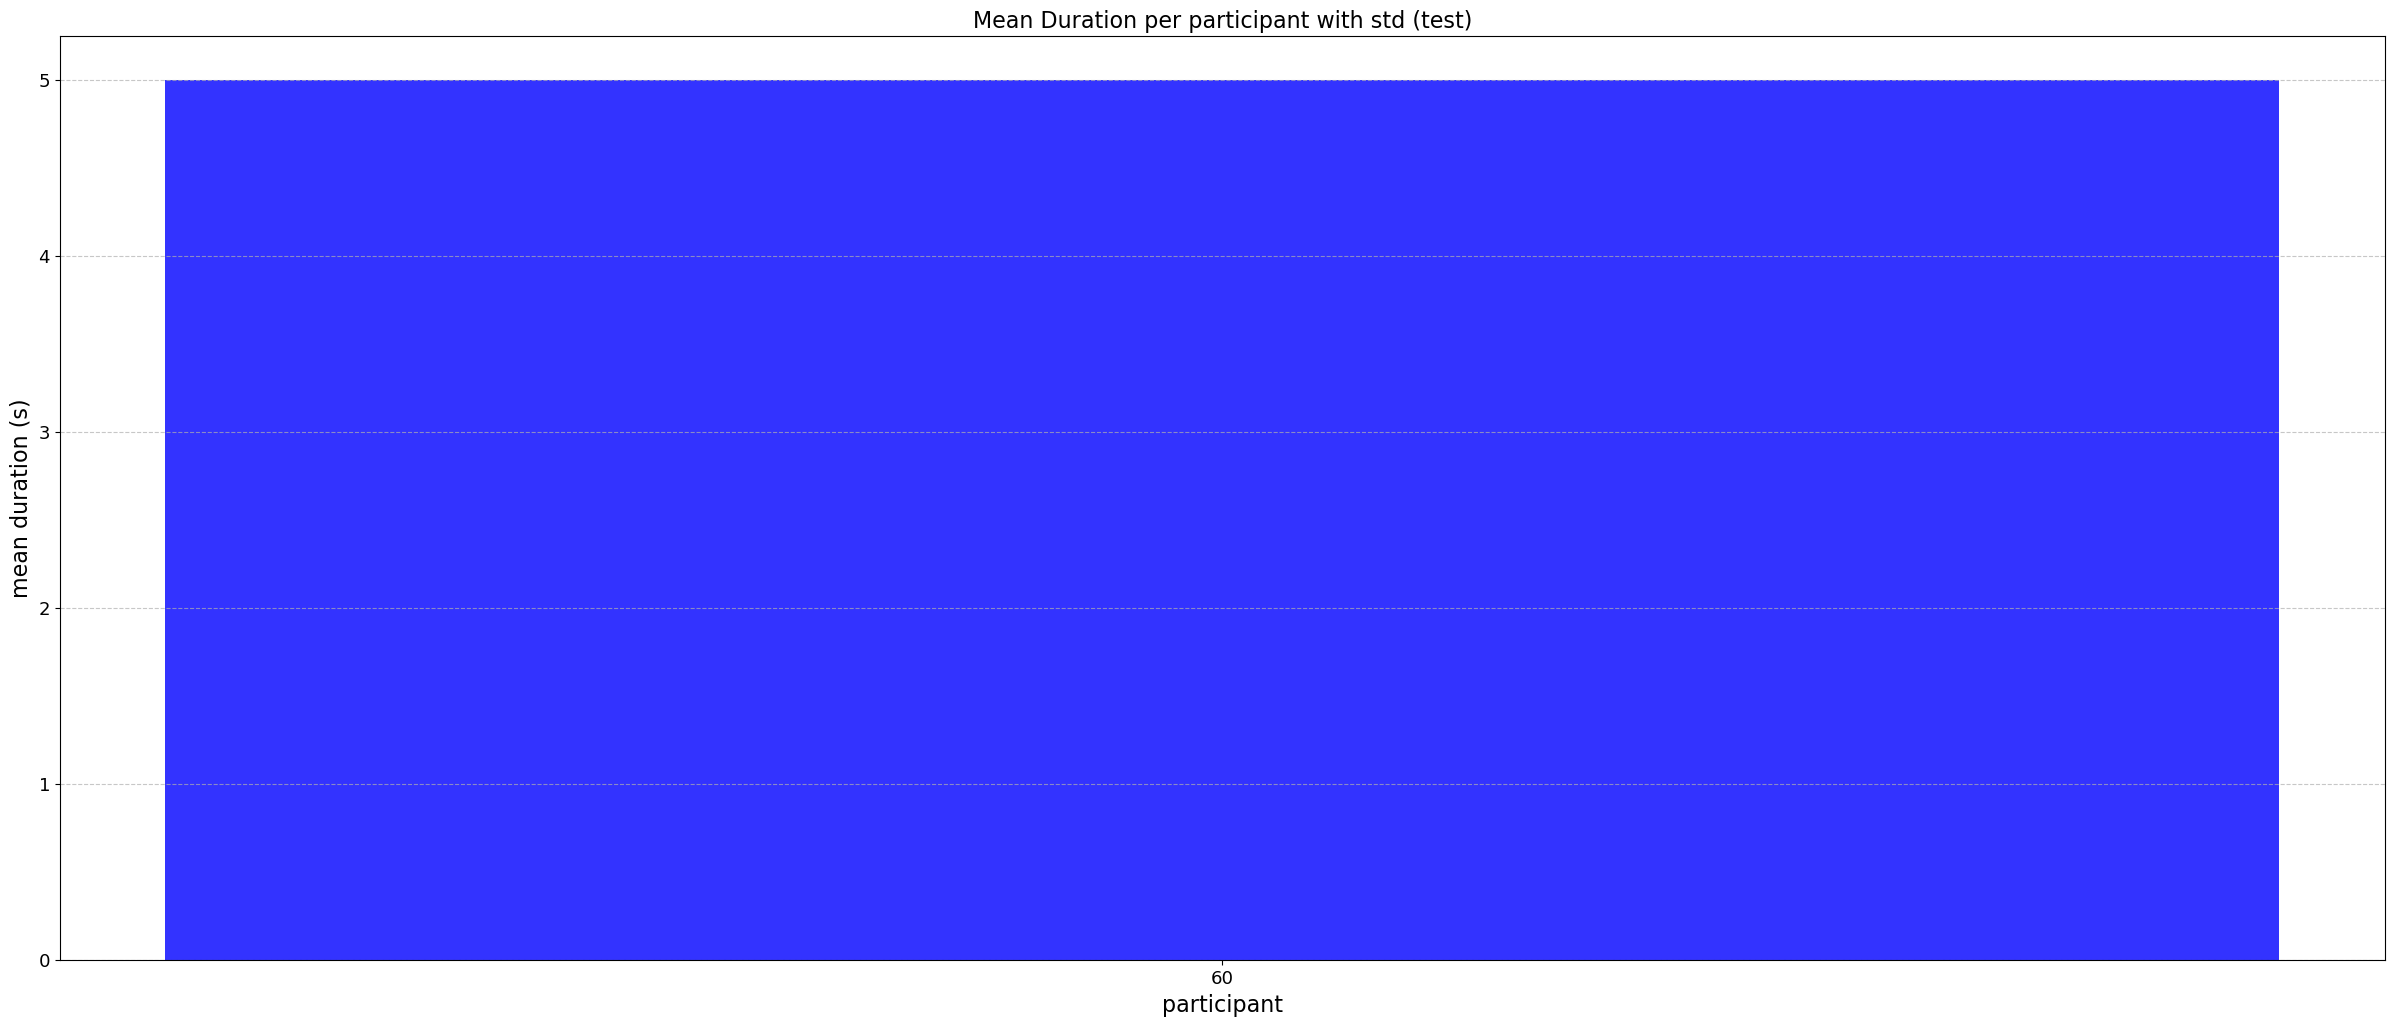

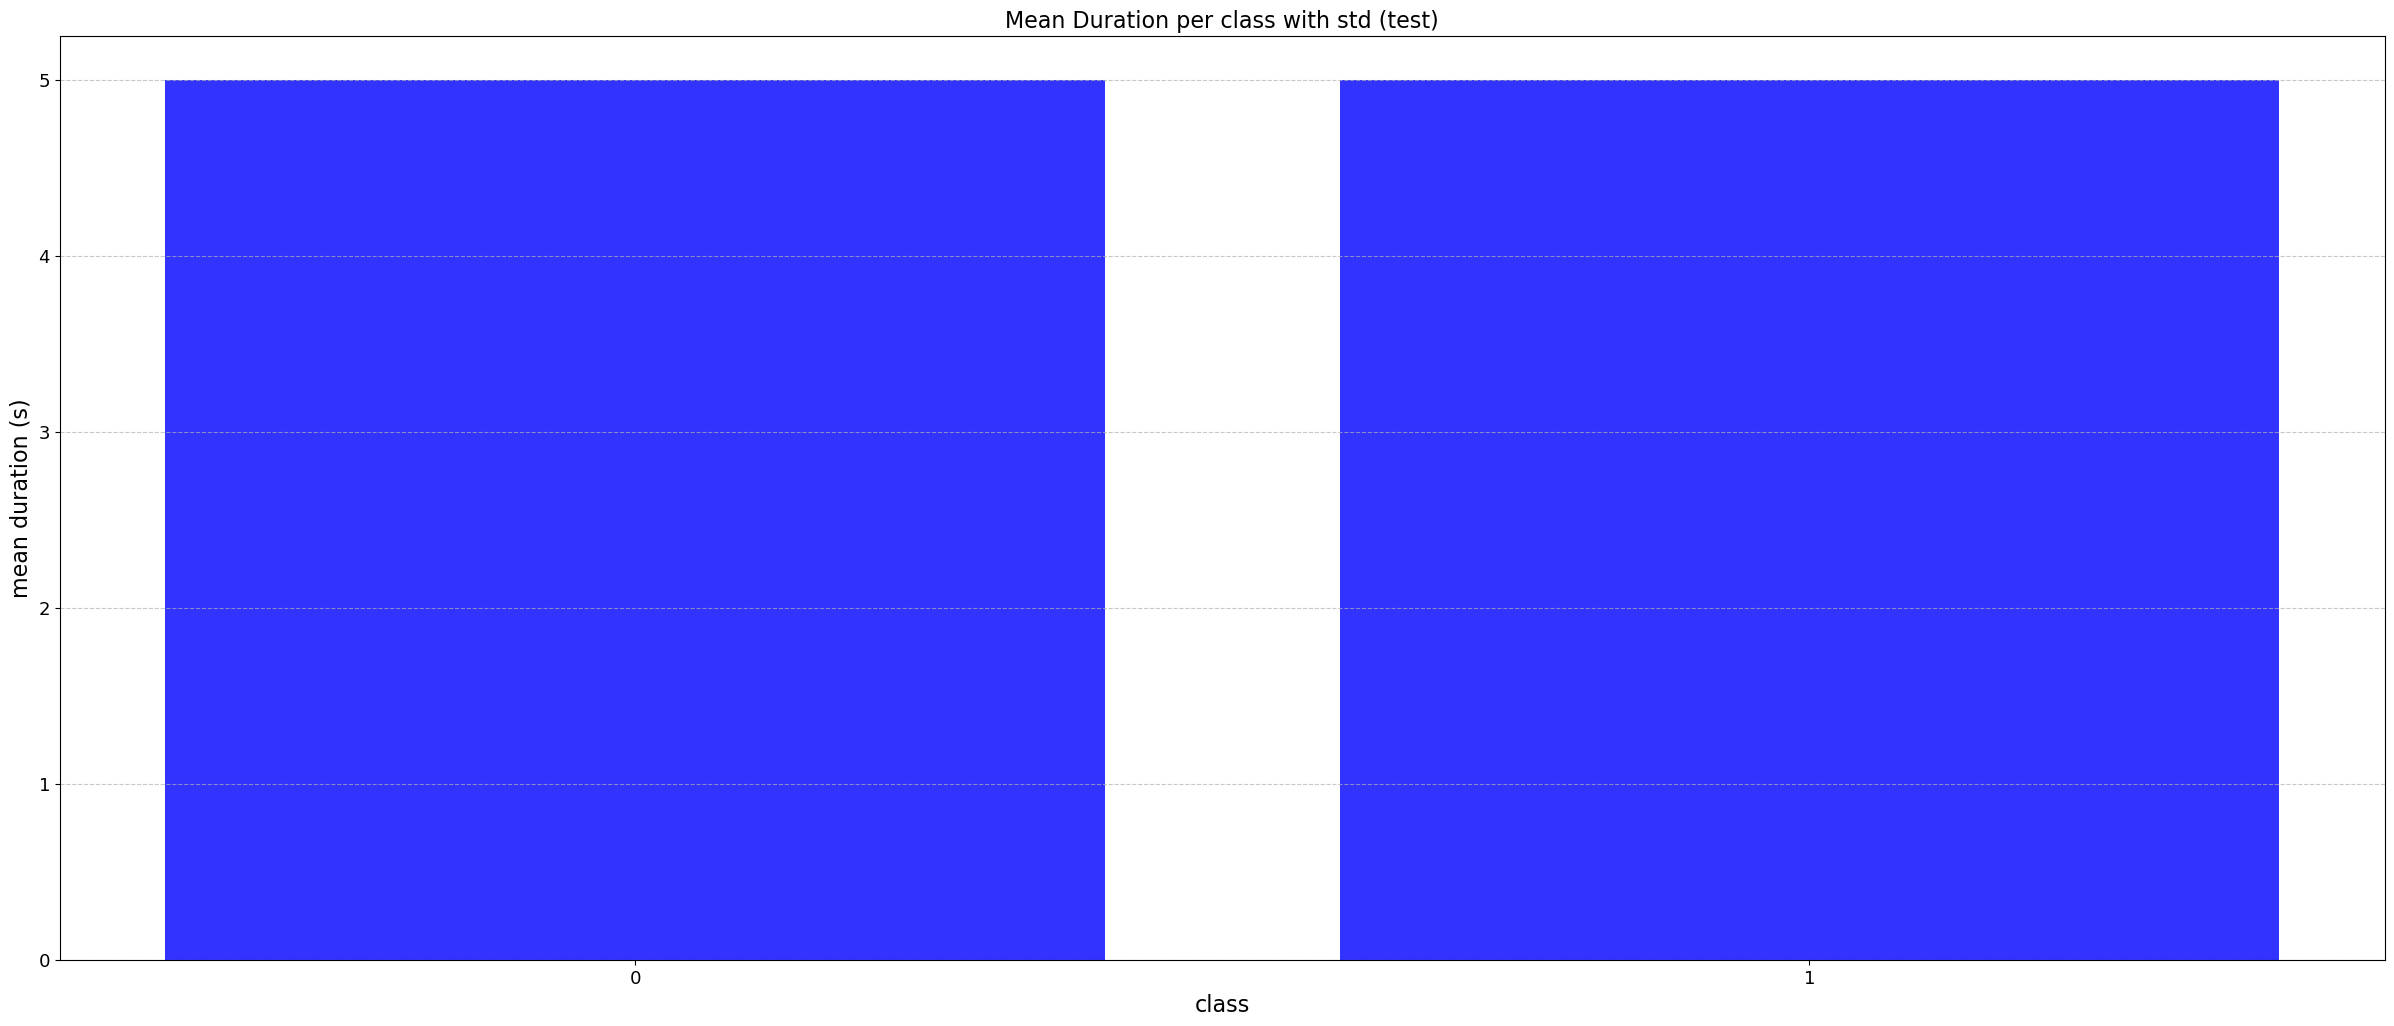

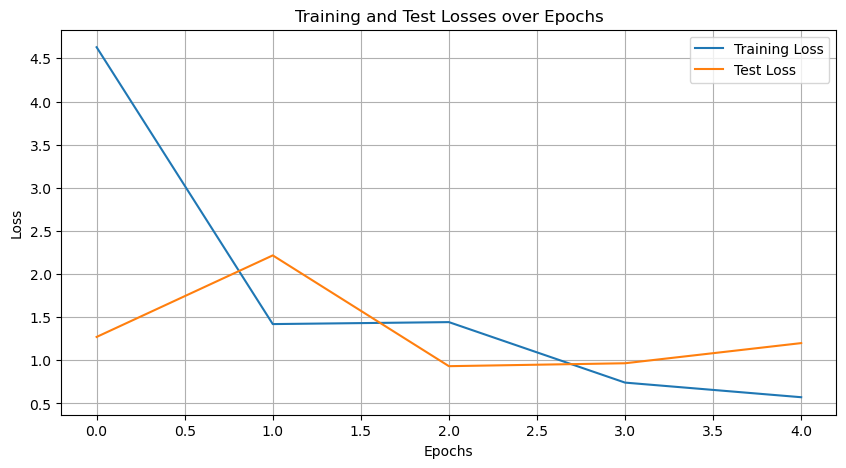

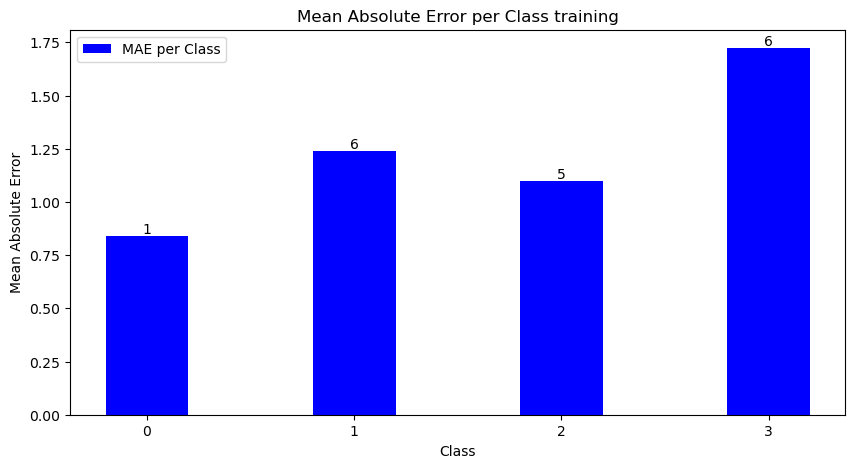

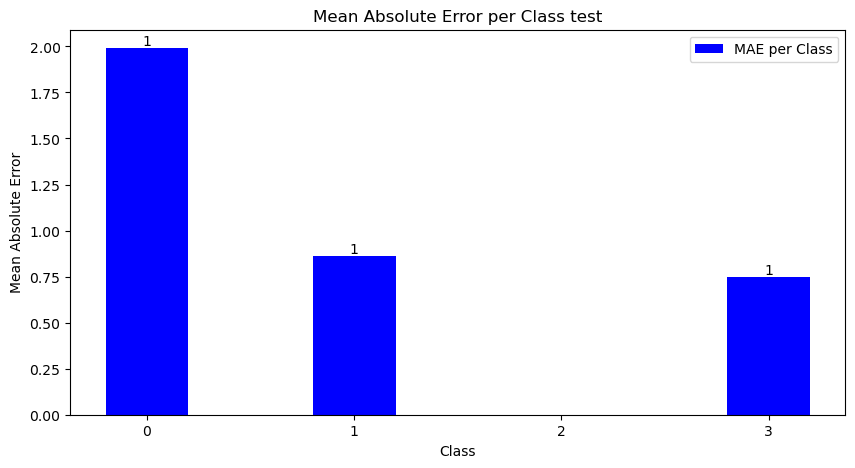

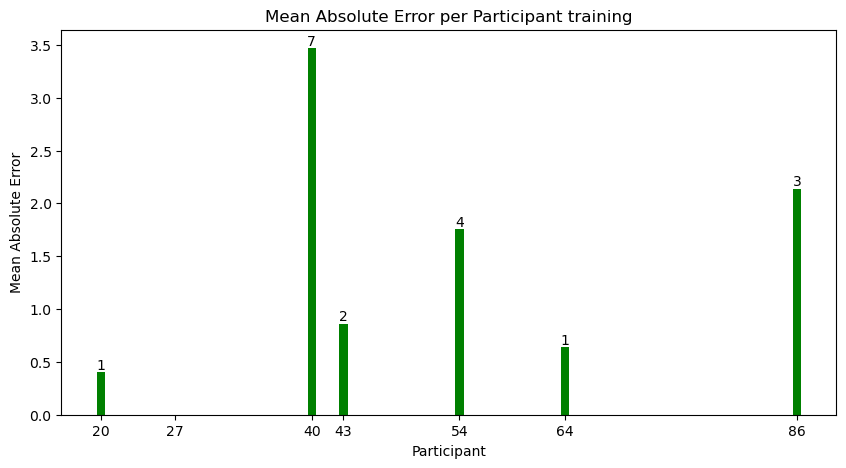

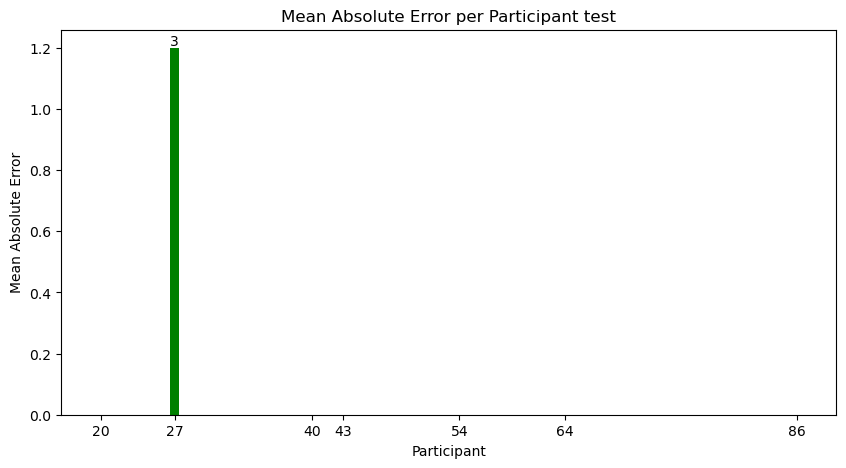

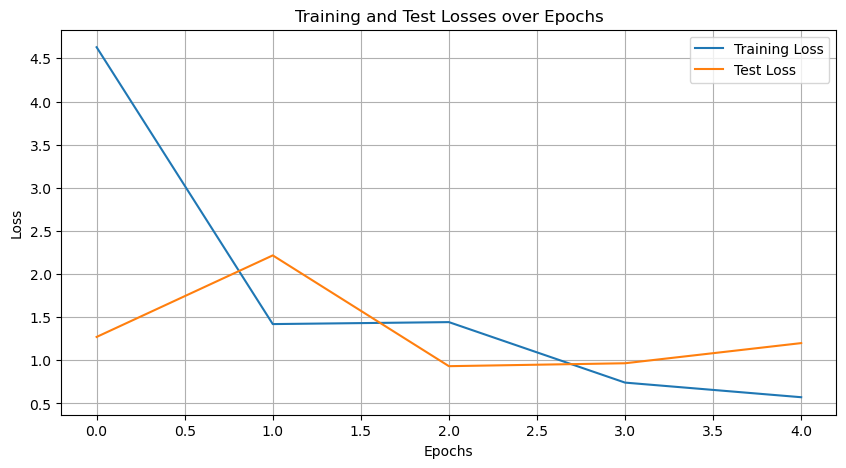

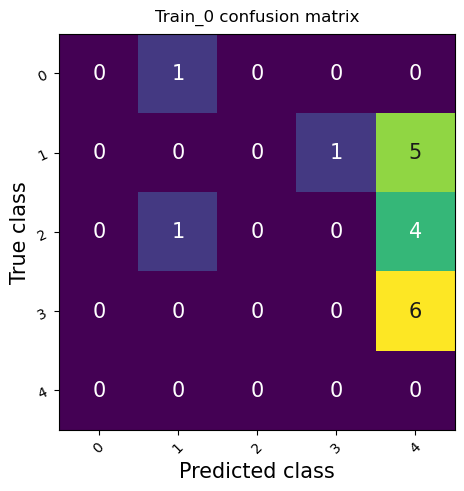

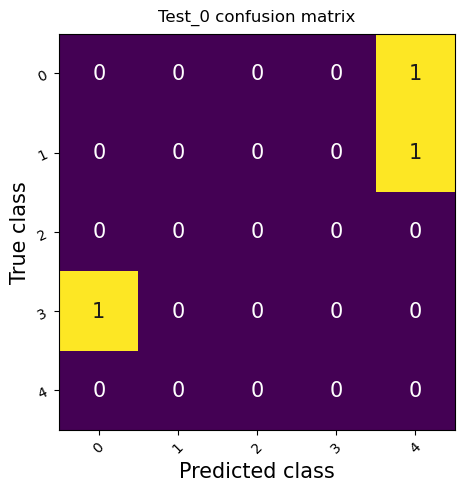

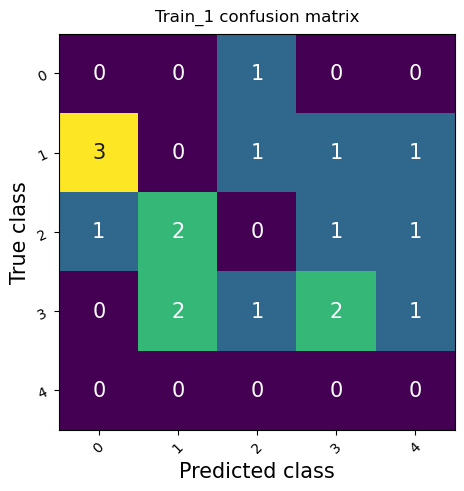

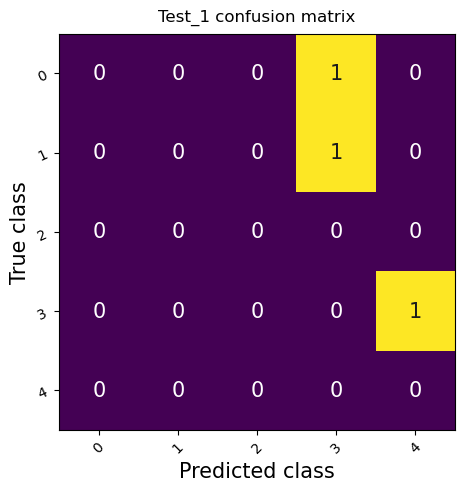

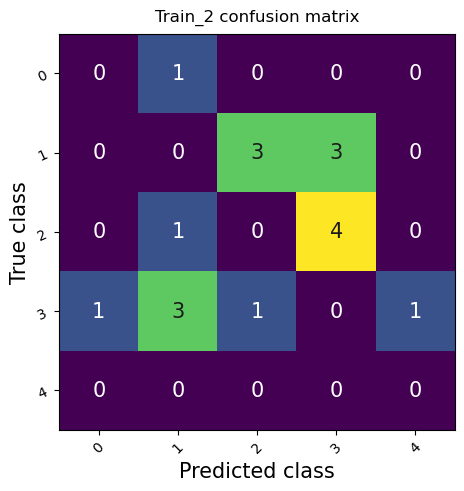

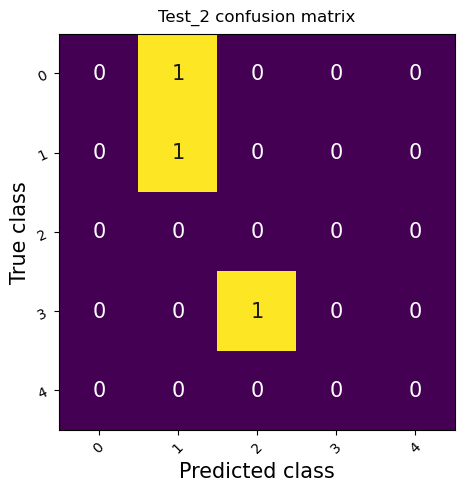

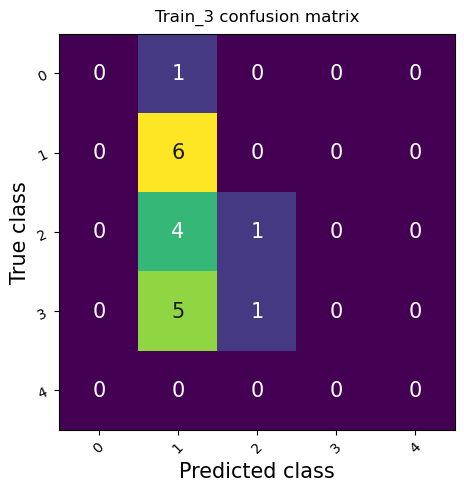

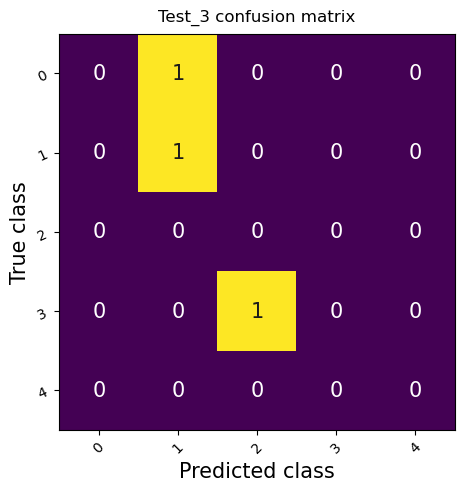

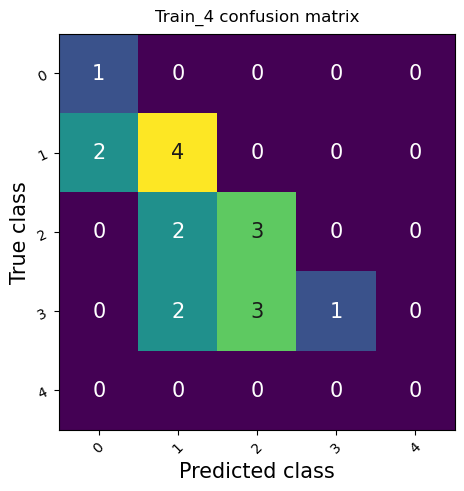

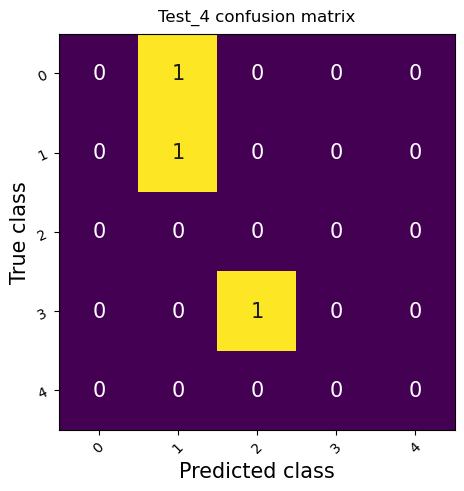

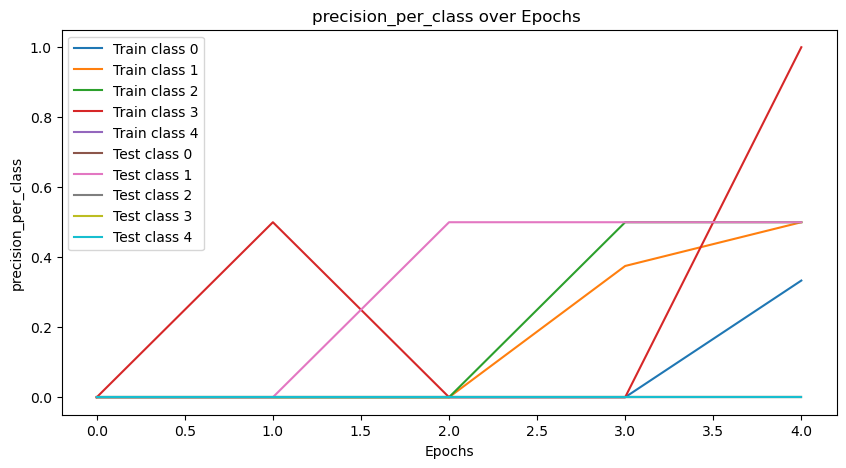

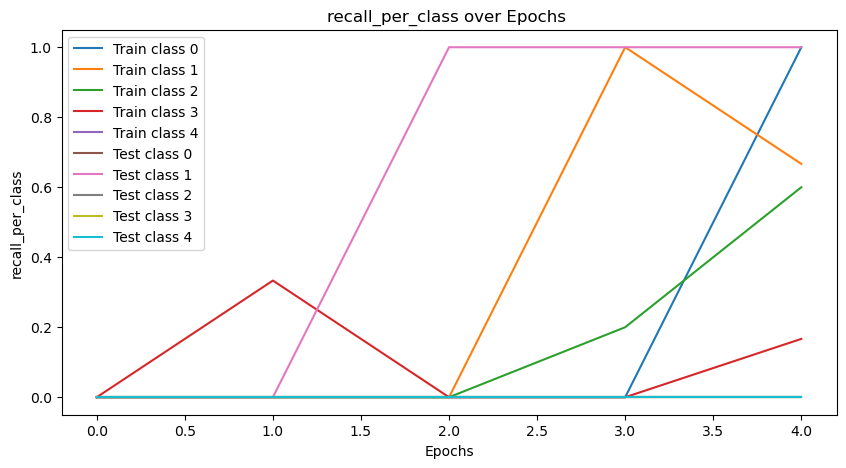

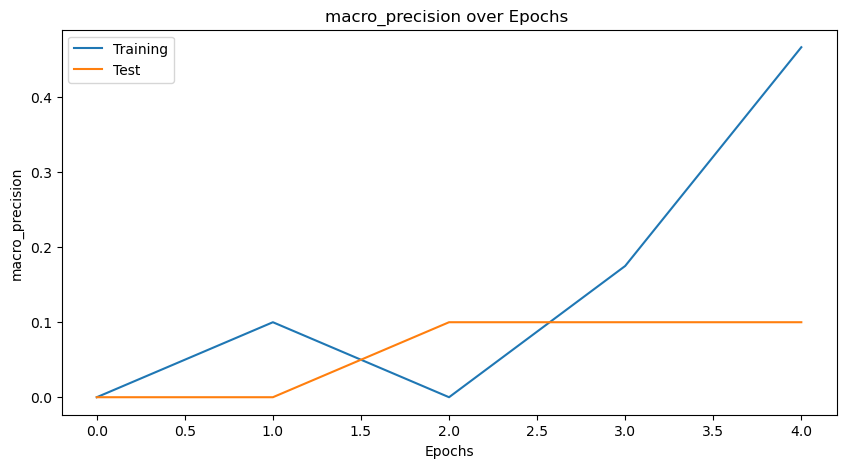

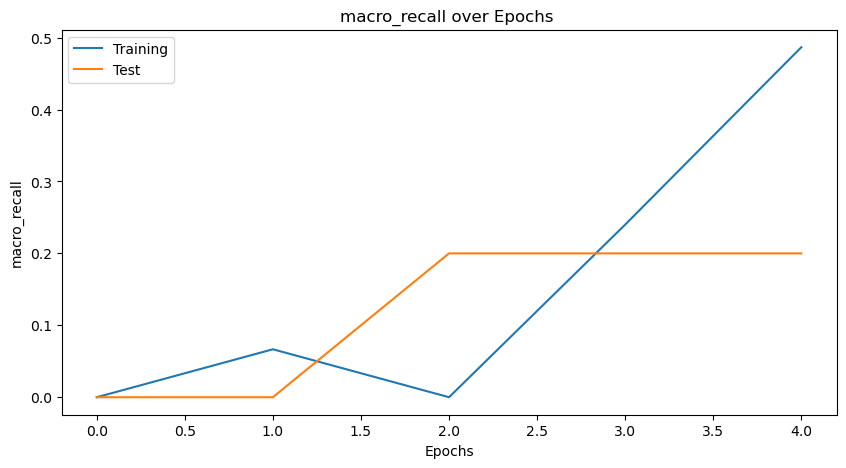

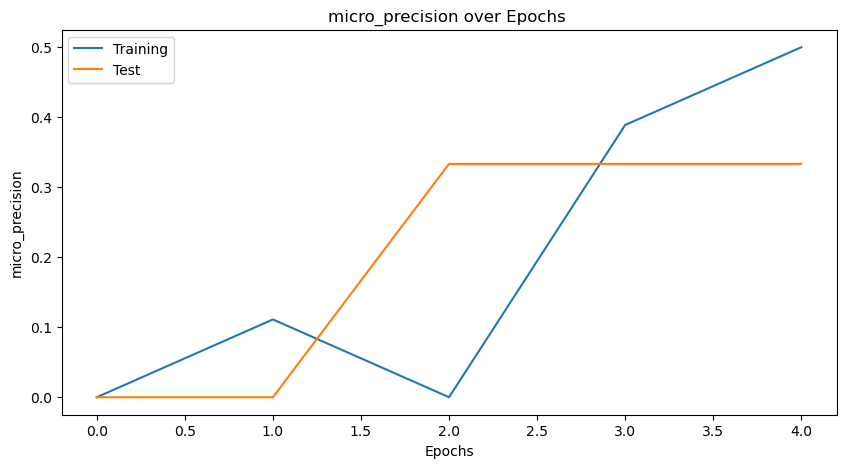

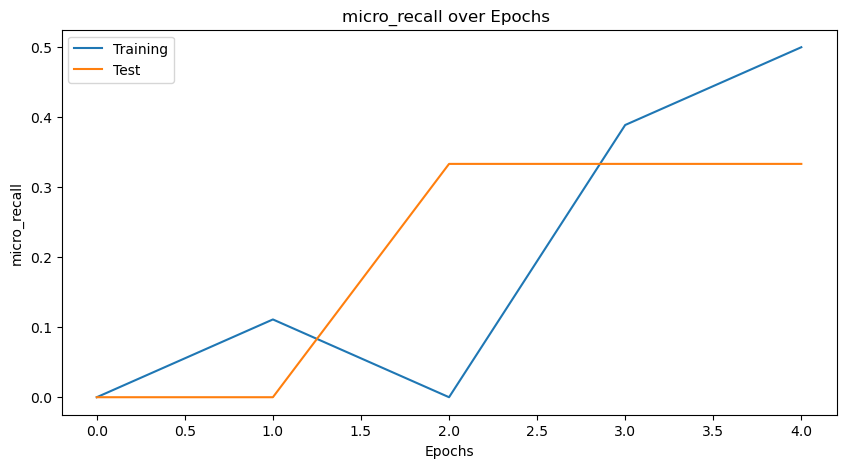

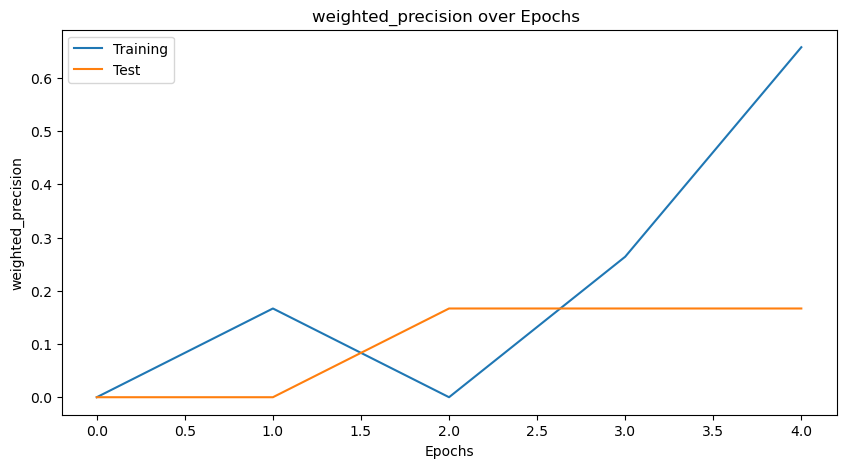

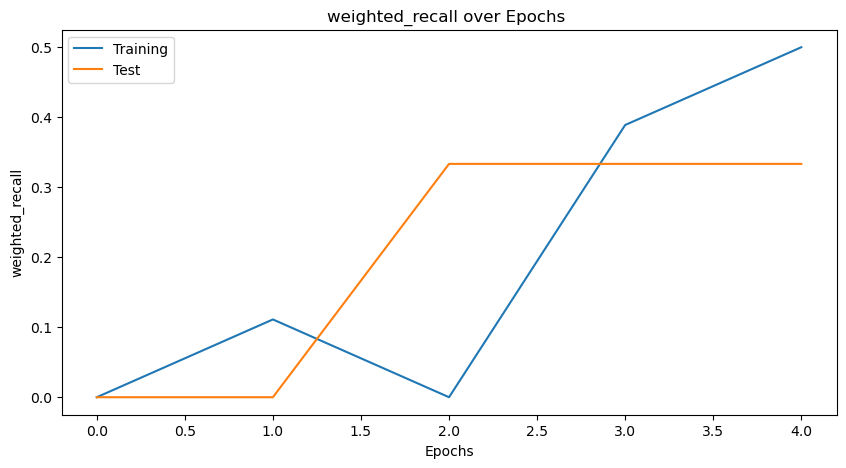

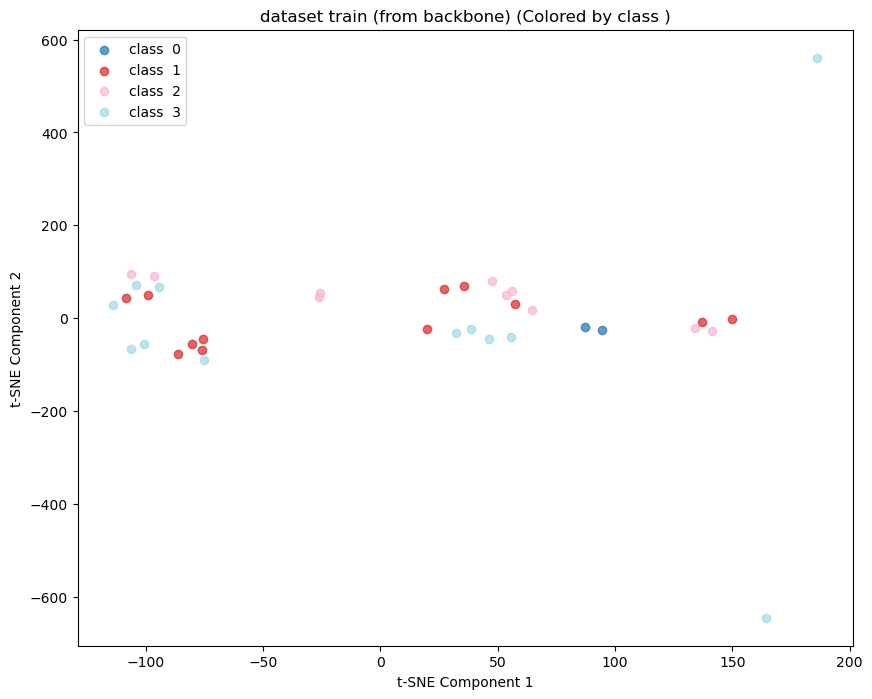

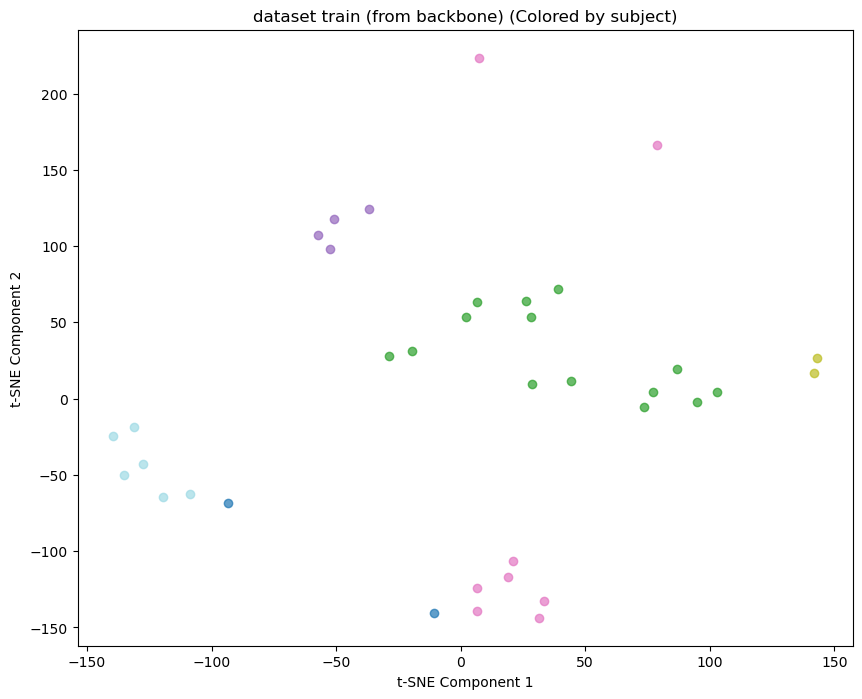

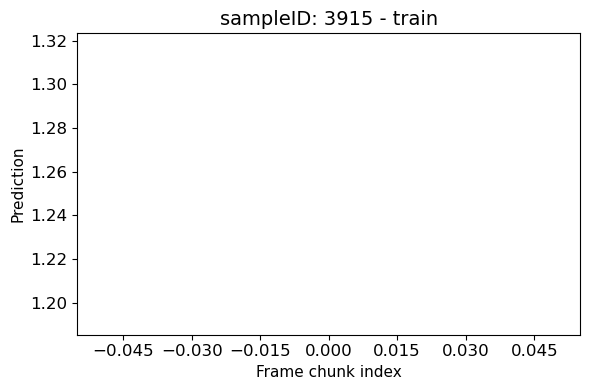

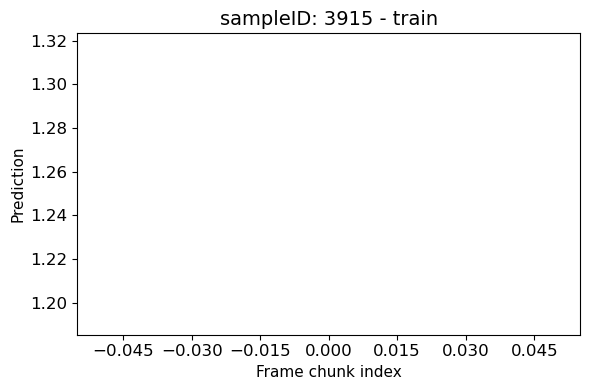

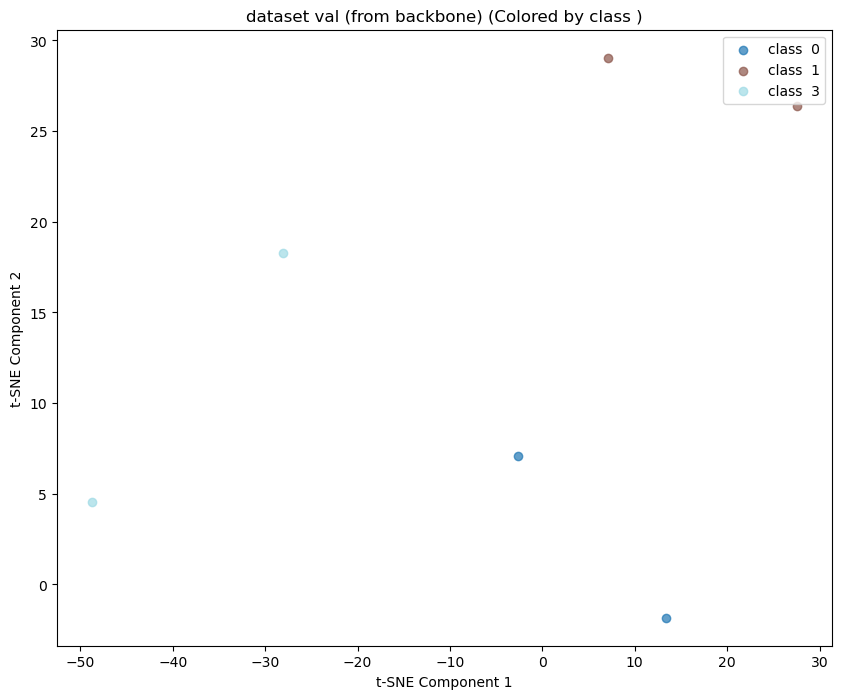

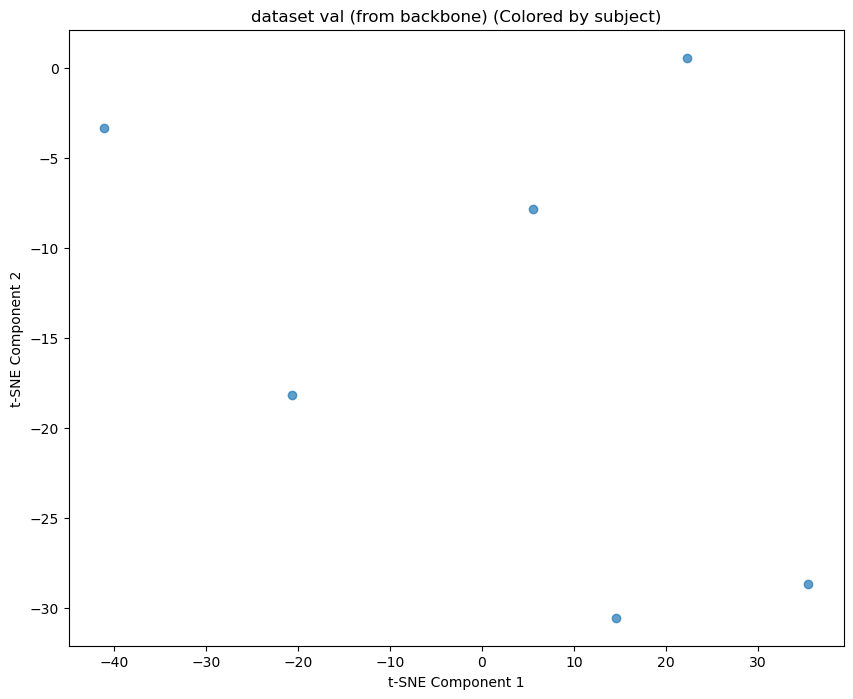

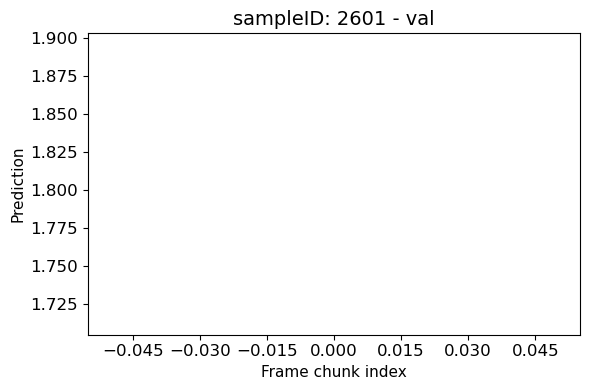

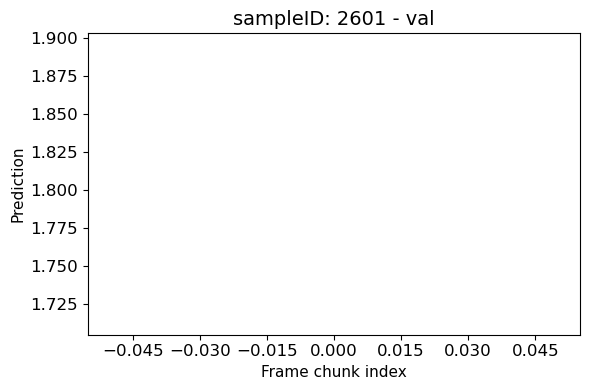

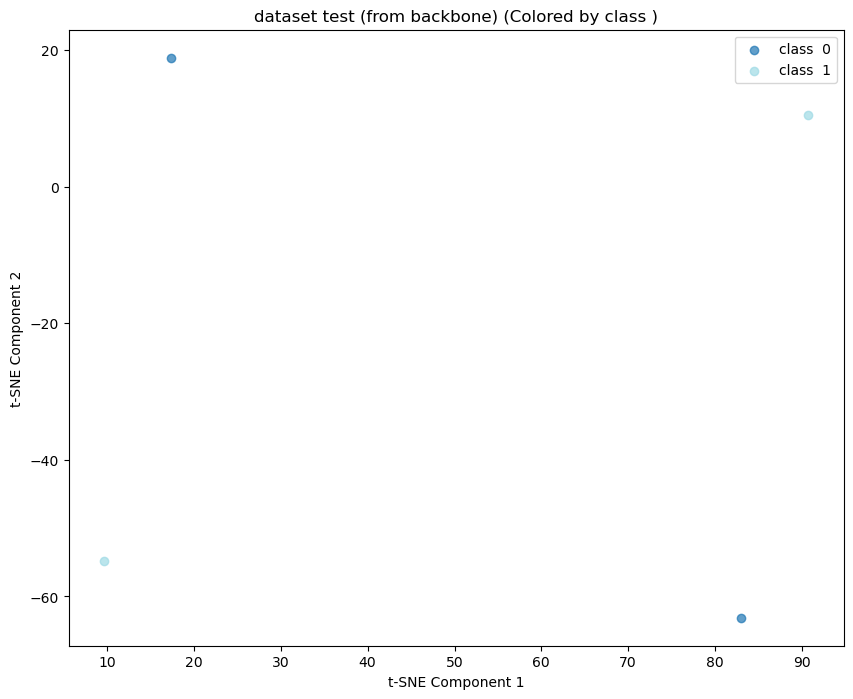

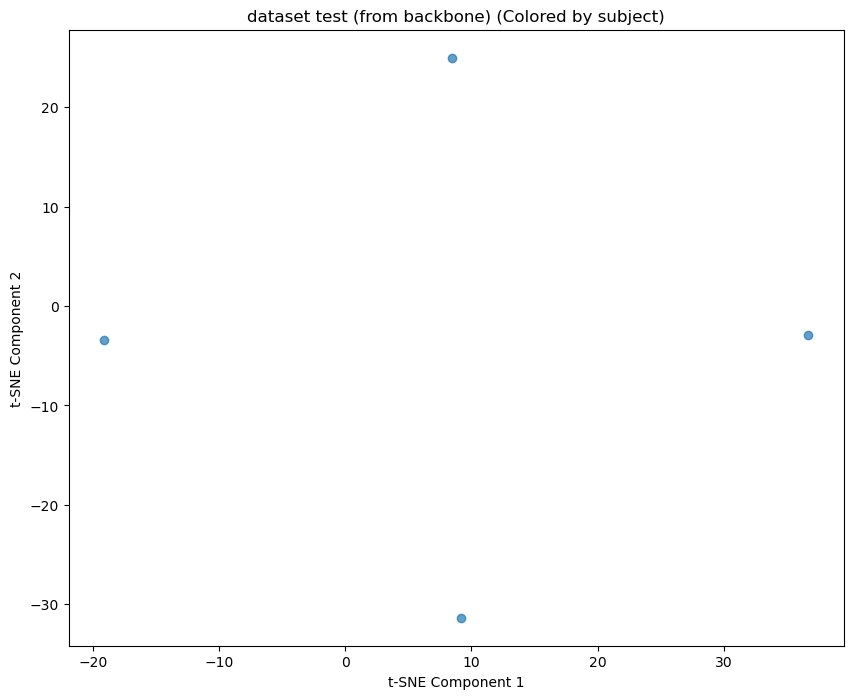

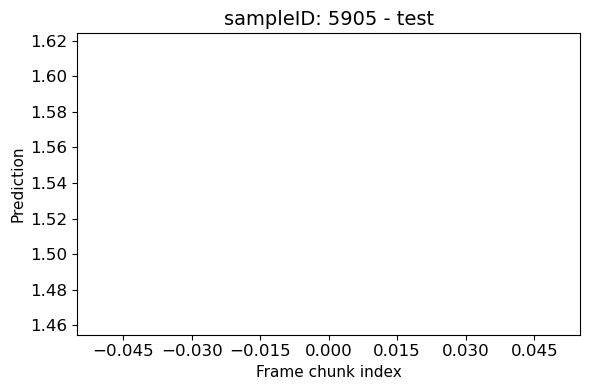

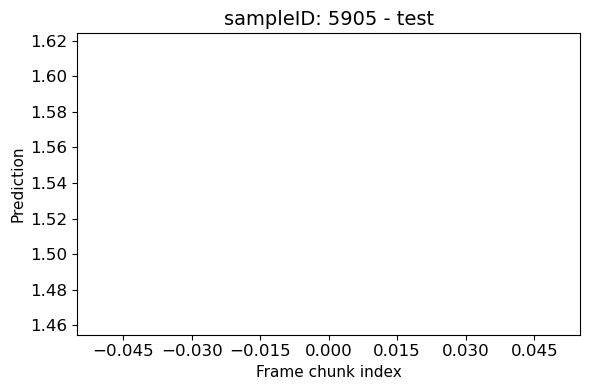

In [3]:
%load_ext autoreload
%autoreload 2
from custom.helper import CLIPS_REDUCTION,EMBEDDING_REDUCTION,MODEL_TYPE,SAMPLE_FRAME_STRATEGY, HEAD
import os
from custom.model import Model_Advanced
from transformers import AutoImageProcessor
from custom.head import HeadSVR, HeadGRU
import time

import custom.scripts as scripts

model_type = MODEL_TYPE.VIDEOMAE_v2_S
pooling_embedding_reduction = EMBEDDING_REDUCTION.MEAN_SPATIAL
pooling_clips_reduction = CLIPS_REDUCTION.NONE
sample_frame_strategy = SAMPLE_FRAME_STRATEGY.SLIDING_WINDOW
# path_dict ={
#   'all' : os.path.join('partA','starting_point','samples.csv'),
  # 'train' : os.path.join('partA','starting_point','train_21.csv'),
  # 'val' : os.path.join('partA','starting_point','val_26.csv'),
  # 'test' : os.path.join('partA','starting_point','test_5.csv')
# }
path_dataset = os.path.join('partA','video','video')  
path_cvs_dataset = os.path.join('partA','starting_point','test_23.csv')
head = HEAD.GRU
# if head == 'GRU':
params = {
  'hidden_size': 512,
  'num_layers': 1,
  'dropout': 0.0
}
preprocess = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
stride_window_in_video = 70
model_advanced = scripts.run_train_test(model_type=model_type, 
                       pooling_embedding_reduction=pooling_embedding_reduction, 
                       pooling_clips_reduction=pooling_clips_reduction, 
                       sample_frame_strategy=sample_frame_strategy, 
                       path_csv_dataset=path_cvs_dataset, 
                       path_video_dataset=path_dataset,
                       head=head,
                       stride_window_in_video=stride_window_in_video, 
                       head_params=params,
                       preprocess=preprocess,
                       download_if_unavailable=False,
                       k_fold = 1,
                       epochs = 5,
                       train_size=0.8,
                       test_size=0.1,
                       val_size=0.1,
                       is_validation=True
                      #  batch_size=4
                      #  criterion = nn.L1Loss(),
                      #  optimizer_fn = optim.Adam,
                      #  lr = 0.001
                       )

In [10]:
del model_advanced

In [11]:
%autoreload 2
import custom.scripts as scripts

model_advanced.dataset.stride_window = 40
scripts.predict_per_video(
    path_csv='partA/starting_point/samples.csv',
    sample_ids=[10,35],
    model_advanced=model_advanced,
    root_folder_path='history_run/VIDEOMAE_v2_B_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733007378/train_GRU/video',
)

NameError: name 'model_advanced' is not defined

In [16]:
import os

def set_working_directory():
  target_dir = 'PainAssessmentVideo'
  current_dir = os.getcwd()
  if os.path.split(current_dir)[-1] != target_dir:
    while os.path.split(current_dir)[-1] != target_dir:
      current_dir = os.path.dirname(current_dir)
      if current_dir == os.path.dirname(current_dir):  # reached the root directory
        raise FileNotFoundError(f"{target_dir} not found in the directory tree. Please set PainAssessmentVideo as current working directory.")
    os.chdir(current_dir)
  print(f"Current working directory set to: {os.getcwd()}")

def create_folder(path):
  if not os.path.exists(path):
    os.makedirs(path)
    print(f'Folder created: {path}')
  else:
    print(f'Folder already exists: {path}')                                                                                       